# Introduction

- TODO: Write introduction
- TODO: Flesh out sections with text

# Methods

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing as mp
import numpy as np
import pandas as pd
import pickle
import h5py
from IPython.display import display, Math

from scipy.integrate import trapz, cumtrapz, quad
from scipy.interpolate import UnivariateSpline
from scipy.stats import lognorm, norm, truncnorm, rv_continuous

import astropy.constants as const
import astropy.units as u
import astropy.uncertainty as unc
from astropy.cosmology import WMAP9, z_at_value
from astropy.modeling.functional_models import Linear1D, Const1D, Shift, Gaussian1D
from astropy.modeling.tabular import Tabular1D

from tqdm.autonotebook import tqdm

from src.models.agn_proxy import (Hopkins2007QuasarFormationDensity,
                                  LogNormal1D, Const3D, QuasarProxyBinaries, Hopkins2007QuasarFormationDensity,
                                  ModifiedSchechter, Marconi2004BHMF, Hopkins2007QuasarNumberDensity,
                                  Goulding2019J1010Binaries)
from src.models.major_merger import (Schechter1D, Schechter2D,
                                     DoubleSchechter2D, TripleSchechter2D,
                                     PairFraction3D, PairFraction3D_3bins,
                                     Timescale3D, Sesana2013_Schechter,
                                     Sesana2013_DoubleSchechter,
                                     Sesana2013_TripleSchechter)

<ipython-input-1-e3f762b89790>:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Global variables
n_samples = int(2 ** 10)
n_mesh = int(2 ** 5)
n_samples, n_mesh

(1024, 32)

In [3]:
# class declarations
class split_normal(rv_continuous):
    def __init__(self, loc, scale1, scale2, *args, **kwargs):
        self.loc = loc
        self.scale1 = scale1
        self.scale2 = scale2
        self.normalization = 2 / (scale1 + scale2)
        super().__init__(self, *args, **kwargs)
        
    def _pdf(self, x):
        if x < self.loc:
            return self.normalization * truncnorm.pdf(x, self.a, self.b, self.loc, self.scale1)
        else:
            return self.normalization * truncnorm.pdf(x, self.a, self.b, self.loc, self.scale2)
    
    def _cdf(self, x):
        if x < self.loc:
            return self.normalization * self.scale1 * truncnorm.cdf(x, self.a, self.b, self.loc, self.scale1)
        else:
            return 1 - self.normalization * self.scale2 * (1 - truncnorm.cdf(x, self.a, self.b, self.loc, self.scale2))
    
    def _ppf(self, q):
        p = self.scale1 / (self.scale1 + self.scale2)
        
        output = np.where(q <= p,
                          self.loc + self.scale1
                          * truncnorm.ppf(.5 * (self.scale1 + self.scale2) * q
                                          / self.scale1, self.a, self.b),
                          self.loc + self.scale2
                          * truncnorm.ppf(0.5 * ((self.scale1 + self.scale2)
                                                 * (1 + q) - 2 * self.scale1)
                                          / self.scale2, self.a, self.b))
        return np.squeeze(output)

In [4]:
def trunc_norm_dist(a=0, b=np.inf, loc=0, scale=1, size=n_samples):
    return truncnorm.rvs(a=(a - loc) / scale, b=(b - loc) / scale,
                                          loc=loc, scale=scale,
                                          size=size)

## Dependencies/Assumptions

### Shared

#### Parameter space

In [5]:
log_m_bh_min = 7
log_m_bh_max = 10

log_m_bh_range = np.linspace(log_m_bh_min, log_m_bh_max, num=n_mesh)

z_min = 0
z_max = 3
z_range = np.linspace(z_min, z_max, num=n_mesh)

q_min = 0.25
q_max = 1
q_range = np.linspace(q_min, q_max, num=n_mesh)

#### Fiducial values

In [6]:
fidhz = (1 / u.yr).to(u.Hz)

In [7]:
# Calculate the standard deviation from the quoted NANOGrav 5-95% interval
NANOGrav_strain95 = 2.67e-15
NANOGrav_strain05 = 1.37e-15

NANOGrav_log_std = (np.log10(NANOGrav_strain95) - np.log10(NANOGrav_strain05)) / (norm.ppf(.95) - norm.ppf(.05))

In [8]:
# NANOGrav 12.5-yr
NANOGrav_log_strain = unc.normal(np.log10(1.92e-15), std=NANOGrav_log_std, n_samples=n_samples).distribution

In [9]:
quantiles = 10 ** np.quantile(NANOGrav_log_strain, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'h_{{c, \rm{{NG12.5}}}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### Cappellari (2013)

##### $M_{\rm{gal}} - M_{K}$ model parameters

In [10]:
a_cappellari = unc.normal(10.5829, std=0.0086, n_samples=n_samples).distribution
b_cappellari = unc.normal(-0.4449, std=0.0091, n_samples=n_samples).distribution

##### $M_{\rm{gal}} - K$ model

In [11]:
c_intercept = a_cappellari + (b_cappellari * 23)
c_slope = b_cappellari
cappellari_mgal_k = Linear1D(slope=c_slope,
                             intercept=c_intercept,
                             n_models=n_samples)

In [12]:
print(cappellari_mgal_k)
with open('../models/Cappellari2013_mgal_mk_relation.pkl', 'wb') as f:
    pickle.dump(cappellari_mgal_k, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
           slope               intercept      
    -------------------- ---------------------
     -0.4512381137787566    0.1962073500781294
    -0.44520596737306367    0.3463708987351062
     -0.4575191304275519   0.06050394797785863
    -0.46086756245793625 -0.007458354550401225
     -0.4352895965995133    0.5702999624522604
    -0.43610981610326893    0.5518049725049394
     -0.4323483567411369    0.6372131736924214
    -0.44313205392093136    0.3894701303396264
     -0.4528707210341834   0.18243640853861542
     -0.4456846787635791    0.3188984460352877
                     ...                   ...
      -0.426543482554769    0.7657638038396382
    -0.44297543556546526    0.3901782648443817
    -0.45513872694977897   0.10137229328395314
     -0.4629187104567721  -0.07448771014134081
    -0.44332001394694615   0.39278116181571754
    -0.41051239425337016    1.1575360816301377
    -0.44241631134735615   

#### McConnell & Ma (2013)

##### $M - M_{\rm{bulge}}$ model parameters

In [13]:
alpha_mcconnell_ma = unc.normal(8.46, std=.08, n_samples=n_samples).distribution
beta_mcconnell_ma = unc.normal(1.05, std=.11, n_samples=n_samples).distribution
intrinsic_disp_mcconnell_ma = np.random.normal(scale=.34, size=n_samples)

##### $M - M_{\rm{bulge}}$ model

Scaled to $M_{\rm{bulge}} / 10^{11}\;\rm{M}_{\odot}$

In [14]:
mm_intercept = alpha_mcconnell_ma - (beta_mcconnell_ma * 11)
mm_slope = beta_mcconnell_ma
mcconnell_ma_m_mbulge = Linear1D(slope=mm_slope,
                                 intercept=mm_intercept,
                                 n_models=n_samples)

In [15]:
print(mcconnell_ma_m_mbulge)
with open('../models/McConnellMa2013_mbh_mbulge_relation.pkl', 'wb') as f:
    pickle.dump(mcconnell_ma_m_mbulge, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          slope             intercept     
    ------------------ -------------------
    1.1134042765939753 -3.7864695230283623
    0.9761807961413058 -2.3321683776929394
    1.1480781959029112  -4.217239729151771
    0.9969329105168574 -2.4637349036660385
    0.8739815117474841 -1.2241650344030575
    1.0908231292441706  -3.536197097963697
    1.0448902096633799 -3.1171026811678786
    1.0394582502322403 -3.0414150322834175
    1.0422096889653358  -2.935330400872484
    1.1316980803064858  -3.931557670657009
                   ...                 ...
    1.2661298141552306  -5.354789220494226
    0.9074536774359552  -1.578706935961307
    1.1258335428501718  -3.846549745563479
    0.9857268575547471 -2.2648615314568197
      0.91407570852941  -1.652005643991302
    1.2627609482368471     -5.476744230403
    0.9148112704900513 -1.7152663329678806
    1.1718418426058215  -4.349801069423517
     1.1173773787

#### Mingarelli+ (2017)

In [16]:
distance = 225. * u.Mpc

z_225 = z_at_value(WMAP9.angular_diameter_distance, distance, zmax=1.)
vol = WMAP9.comoving_volume(z_225).value

#### $M_{\rm{BH}} - M_{\rm{K}}$

In [17]:
log_m_bh_m_k = cappellari_mgal_k | mcconnell_ma_m_mbulge

##### Mass ratio range

In [18]:
q_min_mingarelli = .25
q_max_mingarelli = 1

##### Mass ranges

In [19]:
galaxies = pd.read_csv('../data/external/25/added_mks.lst', delimiter='\s+',
                       usecols=[0, 1, 2, 3, 4], index_col=False)
galaxies = galaxies.append(pd.read_csv('../data/external/25/schutzMa_extension.txt',
                                       delimiter='\s+',
                                       usecols=[0, 1, 2, 3, 4],
                                       index_col=False))
catalog = pd.read_csv('../data/external/25/2mass_galaxies.lst', delimiter='\s+',
                      usecols=[1, 2, 3, 4, 5], index_col=False,
                      names=['RA', 'DEC', 'D_L(Mpc)', 'Kmag', 'Name'])
catalog

,RA,DEC,D_L(Mpc),Kmag,Name
0,189.998,-11.623,14.63,-25.88,NGC4594
1,187.445,8.000,20.78,-26.20,NGC4472
2,50.674,-37.208,19.76,-25.90,NGC1316
3,190.917,11.553,20.78,-25.86,NGC4649
4,187.706,12.391,20.78,-25.78,NGC4486
...,...,...,...,...,...
5105,214.458,0.511,223.09,-25.11,PGC051063
5106,64.351,-37.282,216.26,-25.05,PGC014806
5107,123.188,11.632,223.76,-25.13,PGC1396460
5108,206.159,21.093,218.77,-25.30,PGC3089894


In [20]:
log_m_bhb_mingarelli = np.array([log_m_bh_m_k(Mk) for Mk in catalog['Kmag']])
log_m_bhb_mingarelli = np.random.normal(log_m_bhb_mingarelli, .34)
log_m_bhb_mingarelli_q = np.quantile(log_m_bhb_mingarelli, q=[.16, .5, .84], axis=1)
log_m_bhb_mingarelli_max = np.max(log_m_bhb_mingarelli_q)
log_m_bhb_mingarelli_min = np.min(log_m_bhb_mingarelli_q)
display(Math(r'\log M_{{\rm{{BHB, min, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_min)))
display(Math(r'\log M_{{\rm{{BHB, max, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_max)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
log_m_bh_min_mingarelli = log_m_bhb_mingarelli_min - np.log10(1 + q_min_mingarelli)
log_m_bh_max_mingarelli = log_m_bhb_mingarelli_max - np.log10(1 + q_max_mingarelli)
log_m_bh_max = log_m_bh_max_mingarelli
display(Math(r'\log M_{{\rm{{BH, 1, min, M17}}}} = {0:.2f}'
             .format(log_m_bh_min_mingarelli)))
display(Math(r'\log M_{{\rm{{BH, 1, max, M17}}}} = {0:.2f}'
             .format(log_m_bh_max_mingarelli)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
# Add normalization masses to our mass range explicitly
log_m_bh_norm_min = log_m_bh_min_mingarelli
log_m_bh_norm_max = log_m_bh_max_mingarelli
log_m_bh_range = np.sort(np.append(log_m_bh_range, log_m_bh_norm_min))
log_m_bh_range = np.sort(np.append(log_m_bh_range, log_m_bh_norm_max))
log_m_bh_range_norm = log_m_bh_range[(log_m_bh_range >= log_m_bh_norm_min)
                                     & (log_m_bh_range <= log_m_bh_norm_max)]

In [23]:
# Chirp mass range from M17, used with G19 model
log_m_chirp_norm_min = log_m_bh_min_mingarelli + (1 / 5) * (3 * np.log10(q_min) - np.log10(1 + q_min))
log_m_chirp_norm_max = log_m_bh_max_mingarelli + (1 / 5) * (3 * np.log10(q_max) - np.log10(1 + q_max))
log_m_chirp_range = log_m_bh_range + (3 / 5) * (np.log10(q_max) - (np.log10(1 + q_max) / 3))
log_m_chirp_range = np.sort(np.append(log_m_chirp_range, log_m_chirp_norm_min))
display(Math(r'\log \mathcal{{M}}_{{\rm{{min, M17}}}} = {0:.2f}'
             .format(log_m_chirp_norm_min)))
display(Math(r'\log \mathcal{{M}}_{{\rm{{max, M17}}}} = {0:.2f}'
             .format(log_m_chirp_norm_max)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Quasar-based model

#### $q$ distribution

In [24]:
var_log_q = np.repeat(.5, n_samples)
mode_log_q = np.repeat(0, n_samples)
median_log_q = mode_log_q + (var_log_q ** 2)

In [25]:
q_distrib = LogNormal1D(mu=median_log_q, std=var_log_q, n_models=n_samples)

In [26]:
print(q_distrib)
with open('../models/q_distrib.pkl', 'wb') as f:
    pickle.dump(q_distrib, f)

Model: LogNormal1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
     mu  std
    ---- ---
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
     ... ...
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    Length = 1024 rows


#### Hopkins+ (2007)

##### Differential quasar formation density model parameters

In [27]:
log_formation_rate_normalization = unc.normal(-3.830, std=0.031, n_samples=n_samples).distribution
log_formation_rate_power_law_slope = unc.normal(-4.02, std=0.36, n_samples=n_samples).distribution
log_mass_break_normalization = unc.normal(8.959, std=0.032, n_samples=n_samples).distribution
log_mass_break_k_1 = unc.normal(1.18, std=0.13, n_samples=n_samples).distribution
log_mass_break_k_2 = unc.normal(-6.68, std=0.44, n_samples=n_samples).distribution
low_mass_slope = np.repeat(.2, n_samples)
high_mass_slope_normalization = unc.normal(2.86, std=0.16, n_samples=n_samples).distribution
high_mass_slope_k_1 = unc.normal(1.80, std=0.18, n_samples=n_samples).distribution
high_mass_slope_k_2 = unc.normal(-1.13, std=0.09, n_samples=n_samples).distribution
z_ref = np.repeat(2, n_samples)

##### Differential quasar formation density model

In [28]:
quasar_formation_rate = Hopkins2007QuasarFormationDensity(log_formation_rate_normalization=log_formation_rate_normalization,
                                                          log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                          log_mass_break_normalization=log_mass_break_normalization,
                                                          log_mass_break_k_1=log_mass_break_k_1,
                                                          log_mass_break_k_2=log_mass_break_k_2,
                                                          low_mass_slope=low_mass_slope,
                                                          high_mass_slope_normalization=high_mass_slope_normalization,
                                                          high_mass_slope_k_1=high_mass_slope_k_1,
                                                          high_mass_slope_k_2=high_mass_slope_k_2,
                                                          z_ref=z_ref,
                                                          n_models=n_samples)

In [29]:
print(quasar_formation_rate)
with open('../models/Hopkins2007_quasar_formation_rate_binaries.pkl', 'wb') as f:
    pickle.dump(quasar_formation_rate, f)

Model: Hopkins2007QuasarFormationDensity
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
    log_formation_rate_normalization log_formation_rate_power_law_slope ... z_ref
    -------------------------------- ---------------------------------- ... -----
                 -3.8736503191583123                -3.5933084627104916 ...   2.0
                  -3.863874105368027                -3.9364407626019355 ...   2.0
                 -3.8322651236705703                 -3.963426160324724 ...   2.0
                  -3.861905420604578                -3.6604174624921693 ...   2.0
                  -3.867176169300027                -3.8991465957795146 ...   2.0
                  -3.856531978775205                 -3.907206258828505 ...   2.0
                  -3.890232181272869                -3.8144971101917813 ...   2.0
                  -3.808992913110572                 -4.163043287470473 ...   2.0
                  -3.879437198350568                -4.0449169096972435

### Goulding+ (2019) dual AGN-based model

#### Goulding+ (2019) bounds

##### J1010-like quasar parameters

In [30]:
# Number density luminosity bounds
log_l_min = np.log10((.3 * (10 ** 46.) * u.erg / u.s).to(u.Lsun).value)
log_l_max = np.log10((.3 * (10 ** 47.) * u.erg / u.s).to(u.Lsun).value)
log_l_min_goulding = np.repeat(log_l_min, n_samples)
log_l_max_goulding = np.repeat(log_l_max, n_samples)

log_m_min_goulding = 8
log_m_max_goulding = 10

log_m_chirp_min_goulding = log_m_min_goulding + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))
log_m_chirp_max_goulding = log_m_max_goulding + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))

log_m_bh_min_goulding = log_m_min_goulding - np.log10(1 + q_max)
log_m_bh_max_goulding = log_m_max_goulding - np.log10(1 + q_max)

In [31]:
log_l_min, log_l_max

(11.894149325614856, 12.894149325614856)

#### Sheth+ (2003)

##### Velocity dispersion function parameters

In [32]:
dispersion_normalization_sheth = unc.normal(0.002, std=.0001, n_samples=n_samples).distribution * (WMAP9.h ** 3)
dispersion_break_sheth = np.repeat(88.8, n_samples)  # unc.normal(88.8, std=17.7, n_samples=n_samples).distribution
alpha_sheth = np.repeat(6.5, n_samples)  # unc.normal(6.5, std=1., n_samples=n_samples).distribution
beta_sheth = np.repeat(1.93, n_samples)

##### Velocity dispersion function

In [33]:
sheth_2003_velocity_dispersion_function = ModifiedSchechter(normalization=dispersion_normalization_sheth,
                                                            sigma_break=dispersion_break_sheth,
                                                            alpha=alpha_sheth,
                                                            beta=beta_sheth,
                                                            n_models=n_samples)

In [34]:
print(sheth_2003_velocity_dispersion_function)
with open('../models/Sheth2003_velocity_dispersion_function.pkl', 'wb') as f:
    pickle.dump(sheth_2003_velocity_dispersion_function, f)

Model: ModifiedSchechter
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        normalization     sigma_break alpha beta
    --------------------- ----------- ----- ----
    0.0006582238132407249        88.8   6.5 1.93
    0.0006336904010253055        88.8   6.5 1.93
    0.0006345184956032234        88.8   6.5 1.93
    0.0006543038838996549        88.8   6.5 1.93
    0.0007025189690668622        88.8   6.5 1.93
    0.0006757640421259731        88.8   6.5 1.93
    0.0006538728182680245        88.8   6.5 1.93
    0.0006567496518968947        88.8   6.5 1.93
    0.0007436648838738894        88.8   6.5 1.93
    0.0007106825897555773        88.8   6.5 1.93
                      ...         ...   ...  ...
    0.0006569034427251711        88.8   6.5 1.93
    0.0006535239908058373        88.8   6.5 1.93
    0.0007325998178667164        88.8   6.5 1.93
    0.0006859557840114993        88.8   6.5 1.93
    0.0006984681080080741        88.8   6.5 1.93
     0.000688343028676297    

#### Marconi+ (2004)

##### Black hole mass function parameters

In [35]:
b_marconi = unc.normal(4.11, std=.33, n_samples=n_samples).distribution
a_marconi = unc.normal(8.30, std=.07, n_samples=n_samples).distribution - 2.3 * b_marconi
intrinsic_disp_marconi = np.repeat(.3, n_samples)

##### Black hole mass function

In [36]:
marconi_2004_black_hole_mass_function = Marconi2004BHMF(mass_dispersion_intercept=a_marconi,
                                                        mass_dispersion_slope=b_marconi,
                                                        intrinsic_scatter=intrinsic_disp_marconi,
                                                        dispersion_norm=dispersion_normalization_sheth,
                                                        log_dispersion_break=np.log10(dispersion_break_sheth),
                                                        dispersion_alpha=alpha_sheth,
                                                        dispersion_beta=beta_sheth,
                                                        n_models=n_samples)

In [37]:
print(marconi_2004_black_hole_mass_function)
with open('../models/Marconi2004_black_hole_mass_function.pkl', 'wb') as f:
    pickle.dump(marconi_2004_black_hole_mass_function, f)

Model: Marconi2004BHMF
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
    mass_dispersion_intercept mass_dispersion_slope ... dispersion_beta
    ------------------------- --------------------- ... ---------------
           -1.702874287727461     4.373199077216244 ...            1.93
           -0.804132644627451    3.9494209281376667 ...            1.93
           -1.813574356013861    4.3875300830710575 ...            1.93
             -1.1081291387788     4.141850098172984 ...            1.93
          -1.1608885800716102     4.131631131810663 ...            1.93
          -1.6469603817140737      4.33087947550266 ...            1.93
          -0.2657016570310091    3.7689510550248237 ...            1.93
          -0.7842806333864445     4.001721918709457 ...            1.93
          -1.3227265623111464     4.169713895691611 ...            1.93
           -1.410073715031933     4.268439799164076 ...            1.93
                          ...                   .

#### Hopkins+ (2007)

##### Quasar luminosity function number density parameters

In [38]:
log_norm_hopkins = unc.normal(-4.825, std=0.060, n_samples=n_samples).distribution
log_break_luminosity_norm_hopkins = unc.normal(13.036, std=0.043, n_samples=n_samples).distribution
log_break_luminosity_k1_hopkins = unc.normal(0.632, std=0.077, n_samples=n_samples).distribution
log_break_luminosity_k2_hopkins = unc.normal(-11.76, std=0.38, n_samples=n_samples).distribution
log_break_luminosity_k3_hopkins = unc.normal(-14.25, std=0.80, n_samples=n_samples).distribution
faint_end_slope_norm_hopkins = unc.normal(0.417, std=0.055, n_samples=n_samples).distribution
faint_end_slope_k_hopkins = unc.normal(-0.623, std=0.132, n_samples=n_samples).distribution
bright_end_slope_norm_hopkins = unc.normal(2.174, std=0.055, n_samples=n_samples).distribution
bright_end_slope_k1_hopkins = unc.normal(1.460, std=0.096, n_samples=n_samples).distribution
bright_end_slope_k2_hopkins = unc.normal(-0.793, std=0.057, n_samples=n_samples).distribution
z_ref_hopkins = np.repeat(2, n_samples)

##### Quasar luminosity function number density

In [39]:
hopkins_2007_quasar_number_density = Hopkins2007QuasarNumberDensity(log_l_min=log_l_min_goulding,
                                                                    log_l_max=log_l_max_goulding,
                                                                    log_norm=log_norm_hopkins,
                                                                    log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                                                    log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                                                    log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                                                    log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                                                    faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                                                    faint_end_slope_k=faint_end_slope_k_hopkins,
                                                                    bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                                                    bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                                                    bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                                                    z_ref=z_ref_hopkins,
                                                                    n_models=n_samples)

In [40]:
print(hopkins_2007_quasar_number_density)
with open('../models/Hopkins2007_quasar_number_density.pkl', 'wb') as f:
    pickle.dump(hopkins_2007_quasar_number_density, f)

Model: Hopkins2007QuasarNumberDensity
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        log_l_min          log_l_max      ... bright_end_slope_k2 z_ref
    ------------------ ------------------ ... ------------------- -----
    11.894149325614856 12.894149325614856 ... -0.7191904212765163   2.0
    11.894149325614856 12.894149325614856 ... -0.8121715070635049   2.0
    11.894149325614856 12.894149325614856 ... -0.7709598955044126   2.0
    11.894149325614856 12.894149325614856 ... -0.8435935087623093   2.0
    11.894149325614856 12.894149325614856 ... -0.8338908733612463   2.0
    11.894149325614856 12.894149325614856 ...  -0.776315526706553   2.0
    11.894149325614856 12.894149325614856 ... -0.8005645024849611   2.0
    11.894149325614856 12.894149325614856 ... -0.7900455100879058   2.0
    11.894149325614856 12.894149325614856 ... -0.8446006059486978   2.0
    11.894149325614856 12.894149325614856 ... -0.7149802907536326   2.0
                   ...            

#### Goulding+ (2019) dual AGN model

##### J1010-like quasar number density

In [41]:
j1010_quasars = Goulding2019J1010Binaries(binary_normalization=np.repeat(1, n_samples),
                                          mass_dispersion_intercept=a_marconi,
                                          mass_dispersion_slope=b_marconi,
                                          intrinsic_scatter=intrinsic_disp_marconi,
                                          dispersion_norm=dispersion_normalization_sheth,
                                          log_dispersion_break=np.log10(dispersion_break_sheth),
                                          dispersion_alpha=alpha_sheth,
                                          dispersion_beta=beta_sheth,
                                          log_l_min=log_l_min_goulding,
                                          log_l_max=log_l_max_goulding,
                                          log_dens_norm=log_norm_hopkins,
                                          log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                          log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                          log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                          log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                          faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                          faint_end_slope_k=faint_end_slope_k_hopkins,
                                          bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                          bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                          bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                          z_ref=z_ref_hopkins,
                                          n_models=n_samples)

### Merger models

#### Bell+ (2003)

##### Galactic mass function parameters

In [42]:
z_bell = 0.
phi_bell = trunc_norm_dist(a=0, b=np.inf, loc=0.0133, scale=0.0006, size=n_samples) * (WMAP9.h ** 3)
log_mgal_break_bell = unc.normal(10.63, std=.01, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
alpha_bell = unc.normal(-0.86, std=.04, n_samples=n_samples).distribution

##### Galactic mass function

In [43]:
bell_2003_galactic_mass_function = Schechter1D(normalization=phi_bell,
                                               log_m_break=log_mgal_break_bell,
                                               exponent=alpha_bell,
                                               n_models=n_samples)

In [44]:
print(bell_2003_galactic_mass_function)
with open('../models/Bell2003_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(bell_2003_galactic_mass_function, f)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        normalization        log_m_break           exponent     
    --------------------- ------------------ -------------------
     0.004346631155350086 10.953170517344525 -0.8127995474266088
    0.0041902057084033115 10.953762973674241 -0.9341033716821234
     0.004371285927576902 10.947360259118115 -0.8907675969816115
     0.004726412691339045 10.940876057790453 -0.8487409820171604
     0.004520951930427233 10.924927597464356  -0.948555175955527
     0.004328436883287486 10.955606495035308 -0.8271720453040631
     0.004609614905631354  10.94567716387122 -0.8501764941838226
     0.004598469832269978 10.951423443687116 -0.7947135499750461
    0.0041502106273334175 10.948632940423678 -0.7890763469895339
     0.004301866169037343 10.959620001610315 -0.8836761493155064
                      ...                ...                 ...
     0.004580116514789629 10.959962320446746 -0.9083362226059055
     0.

#### Borch+ (2006)

##### Galactic mass function parameters

In [45]:
z_borch = np.array([0, .3, .5, .7, .9])
z_range_borch = np.linspace(0, .9, num=n_mesh)

norm_0_borch = trunc_norm_dist(a=0, b=np.inf, loc=37e-4, scale=4e-4, size=n_samples)
norm_3_borch = trunc_norm_dist(a=0, b=np.inf, loc=17e-4, scale=7e-4, size=n_samples)
norm_5_borch = trunc_norm_dist(a=0, b=np.inf, loc=15e-4, scale=5e-4, size=n_samples)
norm_7_borch = trunc_norm_dist(a=0, b=np.inf, loc=11e-4, scale=4e-4, size=n_samples)
norm_9_borch = trunc_norm_dist(a=0, b=np.inf, loc=9e-4, scale=3e-4, size=n_samples)

log_m_gal_0_borch = unc.normal(10.81, std=.1, n_samples=n_samples).distribution
log_m_gal_3_borch = unc.normal(10.97, std=.09, n_samples=n_samples).distribution
log_m_gal_5_borch = unc.normal(10.95, std=.1, n_samples=n_samples).distribution
log_m_gal_7_borch = unc.normal(11.06, std=.18, n_samples=n_samples).distribution
log_m_gal_9_borch = unc.normal(11.01, std=.08, n_samples=n_samples).distribution

alpha_0_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_3_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_5_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_7_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_9_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution

##### Galactic mass function

In [46]:
borch_2006_galactic_mass_function = Schechter2D(norm1=norm_0_borch,
                                                norm2=norm_3_borch,
                                                norm3=norm_5_borch,
                                                norm4=norm_7_borch,
                                                norm5=norm_9_borch,
                                                log_m_break1=log_m_gal_0_borch,
                                                log_m_break2=log_m_gal_3_borch,
                                                log_m_break3=log_m_gal_5_borch,
                                                log_m_break4=log_m_gal_7_borch,
                                                log_m_break5=log_m_gal_9_borch,
                                                exp1=alpha_0_borch,
                                                exp2=alpha_3_borch,
                                                exp3=alpha_5_borch,
                                                exp4=alpha_7_borch,
                                                exp5=alpha_9_borch,
                                                n_models=n_samples)

In [47]:
print(borch_2006_galactic_mass_function)
with open('../models/Borch2006_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(borch_2006_galactic_mass_function, f)

Model: Schechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm1                 norm2         ...         exp5       
    --------------------- --------------------- ... -------------------
    0.0034639855239417083 0.0013425650140898241 ... -0.7131371578303295
     0.003920218005312985 0.0008345766198946711 ... -0.6300857289399182
    0.0032499025903222297  0.002548207233833463 ... -0.7242427705226296
     0.003157346490209204 0.0014328005028973105 ... -0.8010983570143025
     0.003843449536278137 0.0021355821529315464 ... -0.7313410032819793
    0.0032506022898990137 0.0018938054936373226 ... -0.7262138648977133
    0.0037388737728192845 0.0014412297322091315 ... -0.8409182087203241
     0.002843436110357746 0.0024631780268526476 ... -0.7303238896761125
    0.0037092109024668327 0.0016010588953468189 ... -0.7164569224450744
     0.003258204793846074 0.0017233161320209726 ... -0.6703477234121981
                      ...                   ... .

#### Drory+ (2009)

##### Galactic mass function parameters

In [48]:
z_drory = np.array([0, .3, .5, .7, .9])
z_range_drory = np.linspace(0, .9, num=n_mesh)

norm_0_drory_b = phi_bell
norm_3_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_5_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=1.74, scale=.09, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_7_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.16, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_9_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.94, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)

log_m_gal_0_drory_b = log_mgal_break_bell
log_m_gal_3_drory_b = unc.normal(10.90, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_5_drory_b = unc.normal(10.91, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_7_drory_b = unc.normal(10.95, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_9_drory_b = unc.normal(10.92, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)

alpha_0_drory_b = alpha_bell
alpha_3_drory_b = unc.normal(-1.06, std=.03, n_samples=n_samples).distribution
alpha_5_drory_b = unc.normal(-1.05, std=.02, n_samples=n_samples).distribution
alpha_7_drory_b = unc.normal(-.93, std=.04, n_samples=n_samples).distribution
alpha_9_drory_b = unc.normal(-.91, std=.03, n_samples=n_samples).distribution

norm_0_drory_f = np.zeros(n_samples)
norm_3_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.80, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_5_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_7_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.26, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_9_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.12, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)

log_m_gal_0_drory_f = np.zeros(n_samples) - 2. * np.log10(WMAP9.h)
log_m_gal_3_drory_f = unc.normal(9.63, std=.09, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_5_drory_f = unc.normal(9.70, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_7_drory_f = unc.normal(9.75, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_9_drory_f = unc.normal(9.85, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)

alpha_0_drory_f = np.zeros(n_samples)
alpha_3_drory_f = unc.normal(-1.73, std=.09, n_samples=n_samples).distribution
alpha_5_drory_f = unc.normal(-1.76, std=.16, n_samples=n_samples).distribution
alpha_7_drory_f = unc.normal(-1.65, std=.08, n_samples=n_samples).distribution
alpha_9_drory_f = unc.normal(-1.65, std=.24, n_samples=n_samples).distribution

##### Galactic mass function

In [49]:
drory_2009_galactic_mass_function = DoubleSchechter2D(norm11=norm_0_drory_b,
                                                      norm12=norm_3_drory_b,
                                                      norm13=norm_5_drory_b,
                                                      norm14=norm_7_drory_b,
                                                      norm15=norm_9_drory_b,
                                                      norm21=norm_0_drory_f,
                                                      norm22=norm_3_drory_f,
                                                      norm23=norm_5_drory_f,
                                                      norm24=norm_7_drory_f,
                                                      norm25=norm_9_drory_f,
                                                      log_m_break11=log_m_gal_0_drory_b,
                                                      log_m_break12=log_m_gal_3_drory_b,
                                                      log_m_break13=log_m_gal_5_drory_b,
                                                      log_m_break14=log_m_gal_7_drory_b,
                                                      log_m_break15=log_m_gal_9_drory_b,
                                                      log_m_break21=log_m_gal_0_drory_f,
                                                      log_m_break22=log_m_gal_3_drory_f,
                                                      log_m_break23=log_m_gal_5_drory_f,
                                                      log_m_break24=log_m_gal_7_drory_f,
                                                      log_m_break25=log_m_gal_9_drory_f,
                                                      exp11=alpha_0_drory_b,
                                                      exp12=alpha_3_drory_b,
                                                      exp13=alpha_5_drory_b,
                                                      exp14=alpha_7_drory_b,
                                                      exp15=alpha_9_drory_b,
                                                      exp21=alpha_0_drory_f,
                                                      exp22=alpha_3_drory_f,
                                                      exp23=alpha_5_drory_f,
                                                      exp24=alpha_7_drory_f,
                                                      exp25=alpha_9_drory_f,
                                                      n_models=n_samples)

In [50]:
print(drory_2009_galactic_mass_function)
with open('../models/Drory2009_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(drory_2009_galactic_mass_function, f)

Model: DoubleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm11                norm12        ...        exp25       
    --------------------- --------------------- ... -------------------
     0.004346631155350086 0.0010171424447878647 ... -1.4173476438891233
    0.0041902057084033115 0.0010278757214242963 ... -1.6501485391479231
     0.004371285927576902 0.0009127469958960298 ... -1.3280205363079989
     0.004726412691339045 0.0008981084855764501 ... -1.6677170220119562
     0.004520951930427233   0.00104907237490108 ... -1.4381249501544253
     0.004328436883287486 0.0008671848291091817 ...  -1.571784452117264
     0.004609614905631354 0.0010001998863930306 ... -1.9768969481793481
     0.004598469832269978 0.0009605383501499931 ...  -1.623423188862185
    0.0041502106273334175  0.001018019257086925 ... -1.3932462723827574
     0.004301866169037343 0.0009548980075050984 ... -1.4677007572010317
                      ...                  

#### Ilbert+ (2010)

##### Galactic mass function parameters

In [51]:
z_ilbert = np.array([0, .3, .5, .7, .9, 1.1, 1.35, 1.75])
z_range_ilbert = np.linspace(0, 1.75, num=n_mesh)

norm_0_ilbert_q = phi_bell
norm_3_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.12, scale=.07, size=n_samples) * 1e-3
norm_5_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.87, scale=.04, size=n_samples) * 1e-3
norm_7_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.15, scale=.03, size=n_samples) * 1e-3
norm_9_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.03, size=n_samples) * 1e-3
norm_11_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.55, scale=.02, size=n_samples) * 1e-3
norm_135_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.26, scale=.02, size=n_samples) * 1e-3
norm_175_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.1, scale=.04, size=n_samples) * 1e-3

log_m_gal_0_ilbert_q = log_mgal_break_bell
log_m_gal_3_ilbert_q = unc.normal(11.13, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_q = unc.normal(10.97, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_q = unc.normal(10.83, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_q = unc.normal(10.77, std=.01, n_samples=n_samples).distribution
log_m_gal_11_ilbert_q = unc.normal(10.7, std=.03, n_samples=n_samples).distribution
log_m_gal_135_ilbert_q = unc.normal(10.64, std=.14, n_samples=n_samples).distribution
log_m_gal_175_ilbert_q = unc.normal(10.67, std=.1, n_samples=n_samples).distribution

alpha_0_ilbert_q = alpha_bell
alpha_3_ilbert_q = unc.normal(-.91, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_q = unc.normal(-.56, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_q = unc.normal(-.25, std=.04, n_samples=n_samples).distribution
alpha_9_ilbert_q = unc.normal(.04, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_q = unc.normal(.25, std=.08, n_samples=n_samples).distribution
alpha_135_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution
alpha_175_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution

norm_0_ilbert_i = np.zeros(n_samples)
norm_3_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.31, scale=.09, size=n_samples) * 1e-3
norm_5_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.96, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.02, scale=.06, size=n_samples) * 1e-3
norm_9_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.52, scale=.07, size=n_samples) * 1e-3
norm_11_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.05, scale=.04, size=n_samples) * 1e-3
norm_135_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.45, scale=.03, size=n_samples) * 1e-3
norm_175_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.23, scale=.02, size=n_samples) * 1e-3

log_m_gal_0_ilbert_i = np.zeros(n_samples)
log_m_gal_3_ilbert_i = unc.normal(10.96, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_i = unc.normal(10.93, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_i = unc.normal(10.85, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_i = unc.normal(10.73, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_i = unc.normal(10.77, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_i = unc.normal(10.94, std=.03, n_samples=n_samples).distribution
log_m_gal_175_ilbert_i = unc.normal(11.02, std=.03, n_samples=n_samples).distribution

alpha_0_ilbert_i = np.zeros(n_samples)
alpha_3_ilbert_i = unc.normal(-1.20, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_i = unc.normal(-1.02, std=.02, n_samples=n_samples).distribution
alpha_7_ilbert_i = unc.normal(-.9, std=.03, n_samples=n_samples).distribution
alpha_9_ilbert_i = unc.normal(-.54, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_i = unc.normal(-.44, std=.04, n_samples=n_samples).distribution
alpha_135_ilbert_i = unc.normal(-.88, std=.04, n_samples=n_samples).distribution
alpha_175_ilbert_i = unc.normal(-1.03, std=.04, n_samples=n_samples).distribution

norm_0_ilbert_h = np.zeros(n_samples)
norm_3_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.36, scale=.06, size=n_samples) * 1e-3
norm_5_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.46, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.65, scale=.05, size=n_samples) * 1e-3
norm_9_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=1., scale=.06, size=n_samples) * 1e-3
norm_11_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.93, scale=.06, size=n_samples) * 1e-3
norm_135_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.79, scale=.04, size=n_samples) * 1e-3
norm_175_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.39, scale=.3, size=n_samples) * 1e-3

log_m_gal_0_ilbert_h = np.zeros(n_samples)
log_m_gal_3_ilbert_h = unc.normal(10.42, std=.07, n_samples=n_samples).distribution
log_m_gal_5_ilbert_h = unc.normal(10.39, std=.05, n_samples=n_samples).distribution
log_m_gal_7_ilbert_h = unc.normal(10.49, std=.03, n_samples=n_samples).distribution
log_m_gal_9_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_h = unc.normal(10.54, std=.02, n_samples=n_samples).distribution
log_m_gal_175_ilbert_h = unc.normal(10.75, std=.7, n_samples=n_samples).distribution

alpha_0_ilbert_h = np.zeros(n_samples)
alpha_3_ilbert_h = unc.normal(-1.51, std=.04, n_samples=n_samples).distribution
alpha_5_ilbert_h = unc.normal(-1.47, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_h = unc.normal(-1.48, std=.02, n_samples=n_samples).distribution
alpha_9_ilbert_h = unc.normal(-1.33, std=.02, n_samples=n_samples).distribution
alpha_11_ilbert_h = unc.normal(-1.29, std=.02, n_samples=n_samples).distribution
alpha_135_ilbert_h = unc.normal(-1.26, std=.02, n_samples=n_samples).distribution
alpha_175_ilbert_h = unc.normal(-1.3, std=.13, n_samples=n_samples).distribution

##### Galactic mass function

In [52]:
ilbert_2010_galactic_mass_function = TripleSchechter2D(norm11=norm_0_ilbert_q,
                                                       norm12=norm_3_ilbert_q,
                                                       norm13=norm_5_ilbert_q,
                                                       norm14=norm_7_ilbert_q,
                                                       norm15=norm_9_ilbert_q,
                                                       norm16=norm_11_ilbert_q,
                                                       norm17=norm_135_ilbert_q,
                                                       norm18=norm_175_ilbert_q,
                                                       norm21=norm_0_ilbert_i,
                                                       norm22=norm_3_ilbert_i,
                                                       norm23=norm_5_ilbert_i,
                                                       norm24=norm_7_ilbert_i,
                                                       norm25=norm_9_ilbert_i,
                                                       norm26=norm_11_ilbert_i,
                                                       norm27=norm_135_ilbert_i,
                                                       norm28=norm_175_ilbert_i,
                                                       norm31=norm_0_ilbert_h,
                                                       norm32=norm_3_ilbert_h,
                                                       norm33=norm_5_ilbert_h,
                                                       norm34=norm_7_ilbert_h,
                                                       norm35=norm_9_ilbert_h,
                                                       norm36=norm_11_ilbert_h,
                                                       norm37=norm_135_ilbert_h,
                                                       norm38=norm_175_ilbert_h,
                                                       log_m_break11=log_m_gal_0_ilbert_q,
                                                       log_m_break12=log_m_gal_3_ilbert_q,
                                                       log_m_break13=log_m_gal_5_ilbert_q,
                                                       log_m_break14=log_m_gal_7_ilbert_q,
                                                       log_m_break15=log_m_gal_9_ilbert_q,
                                                       log_m_break16=log_m_gal_11_ilbert_q,
                                                       log_m_break17=log_m_gal_135_ilbert_q,
                                                       log_m_break18=log_m_gal_175_ilbert_q,
                                                       log_m_break21=log_m_gal_0_ilbert_i,
                                                       log_m_break22=log_m_gal_3_ilbert_i,
                                                       log_m_break23=log_m_gal_5_ilbert_i,
                                                       log_m_break24=log_m_gal_7_ilbert_i,
                                                       log_m_break25=log_m_gal_9_ilbert_i,
                                                       log_m_break26=log_m_gal_11_ilbert_i,
                                                       log_m_break27=log_m_gal_135_ilbert_i,
                                                       log_m_break28=log_m_gal_175_ilbert_i,
                                                       log_m_break31=log_m_gal_0_ilbert_h,
                                                       log_m_break32=log_m_gal_3_ilbert_h,
                                                       log_m_break33=log_m_gal_5_ilbert_h,
                                                       log_m_break34=log_m_gal_7_ilbert_h,
                                                       log_m_break35=log_m_gal_9_ilbert_h,
                                                       log_m_break36=log_m_gal_11_ilbert_h,
                                                       log_m_break37=log_m_gal_135_ilbert_h,
                                                       log_m_break38=log_m_gal_175_ilbert_h,
                                                       exp11=alpha_0_ilbert_q,
                                                       exp12=alpha_3_ilbert_q,
                                                       exp13=alpha_5_ilbert_q,
                                                       exp14=alpha_7_ilbert_q,
                                                       exp15=alpha_9_ilbert_q,
                                                       exp16=alpha_11_ilbert_q,
                                                       exp17=alpha_135_ilbert_q,
                                                       exp18=alpha_175_ilbert_q,
                                                       exp21=alpha_0_ilbert_i,
                                                       exp22=alpha_3_ilbert_i,
                                                       exp23=alpha_5_ilbert_i,
                                                       exp24=alpha_7_ilbert_i,
                                                       exp25=alpha_9_ilbert_i,
                                                       exp26=alpha_11_ilbert_i,
                                                       exp27=alpha_135_ilbert_i,
                                                       exp28=alpha_175_ilbert_i,
                                                       exp31=alpha_0_ilbert_h,
                                                       exp32=alpha_3_ilbert_h,
                                                       exp33=alpha_5_ilbert_h,
                                                       exp34=alpha_7_ilbert_h,
                                                       exp35=alpha_9_ilbert_h,
                                                       exp36=alpha_11_ilbert_h,
                                                       exp37=alpha_135_ilbert_h,
                                                       exp38=alpha_175_ilbert_h,
                                                       n_models=n_samples)

In [53]:
print(ilbert_2010_galactic_mass_function)
with open('../models/Ilbert2010_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(ilbert_2010_galactic_mass_function, f)

Model: TripleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm11                norm12        ...        exp38       
    --------------------- --------------------- ... -------------------
     0.004346631155350086  0.001117171963693311 ... -1.3199464005990973
    0.0041902057084033115 0.0011920465908541276 ... -1.2578614831236636
     0.004371285927576902 0.0011870347436045605 ... -1.4168432901741852
     0.004726412691339045 0.0009736657836124197 ... -1.2939255855317653
     0.004520951930427233 0.0011481527622042823 ... -1.3687771587710347
     0.004328436883287486 0.0012244950599841354 ... -1.1359115288594954
     0.004609614905631354 0.0011133086377554445 ... -1.2883228759646068
     0.004598469832269978 0.0011256584069259258 ... -1.1695850233412475
    0.0041502106273334175 0.0011711335570011702 ...  -1.370195697163384
     0.004301866169037343  0.001079539201769981 ... -1.0874515480204758
                      ...                  

#### Bundy+ (2009)

##### Pair fraction parameters

In [54]:
m_bundy = unc.normal(1.6, std=1.6, n_samples=n_samples).distribution
fp_bundy = trunc_norm_dist(a=0, b=np.inf, loc=.03, scale=.02, size=n_samples) / (1.55 ** m_bundy)
q_min_bundy = np.repeat(.25, n_samples)
r_proj_bundy = np.repeat(20, n_samples)

In [55]:
np.median(fp_bundy)

0.014798808072852186

##### Pair fraction

In [56]:
bundy_pair_frac = PairFraction3D(normalization=fp_bundy,
                                 exponent=m_bundy,
                                 q_min=q_min_bundy,
                                 n_models=n_samples)

In [57]:
print(bundy_pair_frac)
with open('../models/Bundy2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(bundy_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
        normalization           exponent       q_min
    --------------------- -------------------- -----
     0.005229587233464661    4.276009260315611  0.25
     0.017330137537965903   0.5017753475528668  0.25
     0.010819612062678731   2.7202035579040635  0.25
     0.018598653082726464    1.933866371853302  0.25
     0.005124164222974662     4.21806453814124  0.25
     0.034179580227536366   0.6956419583766768  0.25
      0.01451416173655465   0.3771256996475538  0.25
      0.01874309913776229   1.0551237456735278  0.25
      0.03365318041276807 -0.10847826150204343  0.25
     0.040269520408349205  0.19968832049474772  0.25
                      ...                  ...   ...
     0.005243867639938956   1.6882291786002557  0.25
    0.0017677606911708295   3.3953347666067577  0.25
    0.0039916764068076305   2.1986578525491596  0.25
     0.005528018120945989   5.4348903107049065  0.25


#### de Ravel+ (2009)

##### Pair fraction parameters

In [58]:
log_m_min_de_ravel = np.array([9.5, 10, 10.5])
fp_95_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0390, scale=.0342, size=n_samples)
fp_10_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0728, scale=.0681, size=n_samples)
fp_105_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.167, scale=.195, size=n_samples)

m_95_de_ravel = unc.normal(3.13, std=1.54, n_samples=n_samples).distribution
m_10_de_ravel = unc.normal(2.04, std=1.65, n_samples=n_samples).distribution
m_105_de_ravel = unc.normal(.52, std=2.07, n_samples=n_samples).distribution

q_min_de_ravel = np.repeat(.25, n_samples)
r_proj_de_ravel = np.repeat(100, n_samples)

##### Pair fraction

In [59]:
de_ravel_pair_frac = PairFraction3D_3bins(norm1=fp_95_de_ravel,
                                          norm2=fp_10_de_ravel,
                                          norm3=fp_105_de_ravel,
                                          exp1=m_95_de_ravel,
                                          exp2=m_10_de_ravel,
                                          exp3=m_105_de_ravel,
                                          q_min=q_min_de_ravel,
                                          n_models=n_samples)

In [60]:
print(de_ravel_pair_frac)
with open('../models/deRavel2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(de_ravel_pair_frac, f)

Model: PairFraction3D_3bins
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
            norm1                norm2         ...         exp3         q_min
    --------------------- -------------------- ... -------------------- -----
     0.004797619052080884  0.09557439652679472 ... -0.47697143129144526  0.25
      0.04668360288279111  0.10089320495223093 ...  -1.3235143011637065  0.25
      0.04675252716545247   0.1784724871063973 ...    -5.52912849724035  0.25
     0.016609757267839406  0.11282527317693868 ...    2.920707259002543  0.25
     0.004453261215967029  0.10488451836206464 ...   1.3845899298917286  0.25
      0.06700820399611666  0.08955259556519563 ...  -1.2880690243186517  0.25
      0.02631722245860639  0.05655427349042831 ...   1.5276185768092936  0.25
      0.06054974905414855   0.1023245235689861 ...   0.9760331023152586  0.25
      0.06147603568370197 0.013577071354503215 ...  -0.4571597487458394  0.25
      0.04442557674269353  0.09302474

#### Lopez-Sanjuan+ (2012)

##### Pair fraction parameters

In [61]:
fp_lopez = trunc_norm_dist(a=0, b=np.inf, loc=.019, scale=.003, size=n_samples)
m_lopez = unc.normal(1.4, std=.3, n_samples=n_samples).distribution
q_min_lopez = np.repeat(.25, n_samples)
r_proj_lopez = np.repeat(30, n_samples)

##### Pair fraction

In [62]:
lopez_pair_frac = PairFraction3D(normalization=fp_lopez,
                                 exponent=m_lopez,
                                 q_min=q_min_lopez,
                                 n_models=n_samples)

In [63]:
print(lopez_pair_frac)
with open('../models/Lopez2012_pair_fraction.pkl', 'wb') as f:
    pickle.dump(lopez_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
       normalization          exponent      q_min
    -------------------- ------------------ -----
     0.01334990730099479 1.9681346988755242  0.25
    0.017298389315577044 1.6107185522812382  0.25
    0.014706954505925745 1.6281943188285117  0.25
    0.016279714457269643 1.3144351332144528  0.25
      0.0152795551215774 1.1335353775925734  0.25
    0.022814230850883178  1.553007488385413  0.25
     0.01772028333745195 1.5420574789816979  0.25
    0.013176485203468324 1.8398731144691853  0.25
    0.015344778330482511 1.1494245180801936  0.25
    0.018188620544905318   1.23106839364147  0.25
                     ...                ...   ...
    0.020865193066347647 1.5638341907619058  0.25
     0.01775480389580583 1.5266846590741991  0.25
     0.01741890133955714 1.6027716584902438  0.25
     0.01941918616665824 1.7548830775272053  0.25
    0.023562089239707505  1.165025366852165  0.25
 

#### Kitzbichler & White (2008)

##### Merger timescale normalization

In [64]:
norm_kw = np.repeat(2.2, n_samples)

##### Merger timescale

In [65]:
kw_merger_timescale = Timescale3D(normalization=norm_kw,
                                  r_proj=r_proj_lopez,
                                  n_models=n_samples)

In [66]:
print(kw_merger_timescale)
with open('../models/KitzbichlerWhigte2008_merger_timescale.pkl', 'wb') as f:
    pickle.dump(kw_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    normalization r_proj
    ------------- ------
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              ...    ...
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
    Length = 1024 rows


#### Lotz+ (2010)

##### Merger timescale normalization

In [67]:
norm_lotz = np.repeat(1.1, n_samples)

##### Merger timescale

In [68]:
lotz_merger_timescale = Timescale3D(normalization=norm_lotz,
                                    r_proj=r_proj_de_ravel,
                                    n_models=n_samples)

In [69]:
print(lotz_merger_timescale)
with open('../models/Lotz2010_merger_timescale.pkl', 'wb') as f:
    pickle.dump(lotz_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    normalization r_proj
    ------------- ------
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              ...    ...
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
    Length = 1024 rows


## Main models

### Mingarelli+ 2017 Derived $\Phi_{\rm{BHB}, 0}$

In [70]:
distance = 225. * u.Mpc

z_225 = z_at_value(WMAP9.angular_diameter_distance, distance, zmax=1.)
vol = WMAP9.comoving_volume(z_225).value

z_range = np.sort(np.append(z_range, z_225))

In [71]:
N_BHB = np.rint(trunc_norm_dist(a=0, b=np.inf, loc=91, scale=7, size=n_samples))  # can't have fractions of a SMBHB
local_binaries = Const1D(amplitude=N_BHB, n_models=n_samples)

quantiles = np.quantile(local_binaries(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'N_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [72]:
print(local_binaries)
with open('../models/M17_local_binaries.pkl', 'wb') as f:
    pickle.dump(local_binaries, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
    amplitude
    ---------
         84.0
         85.0
         90.0
         86.0
         88.0
         95.0
         73.0
         73.0
        109.0
         86.0
          ...
         91.0
        104.0
         90.0
         84.0
         99.0
         86.0
         77.0
         93.0
         91.0
         80.0
         97.0
    Length = 1024 rows


In [73]:
local_binary_number_density_mingarelli = Const1D(amplitude=N_BHB/vol, n_models=n_samples)

quantiles = np.quantile(local_binary_number_density_mingarelli(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, M17}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [74]:
print(local_binary_number_density_mingarelli)
with open('../models/M17_number_density.pkl', 'wb') as f:
    pickle.dump(local_binary_number_density_mingarelli, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
     1.496774875231376e-06
    1.5145936237460352e-06
    1.6036873663193313e-06
    1.5324123722606944e-06
    1.5680498692900129e-06
    1.6927811088926275e-06
    1.3007686415701243e-06
    1.3007686415701243e-06
     1.942243588097857e-06
    1.5324123722606944e-06
                       ...
    1.6215061148339906e-06
    1.8531498455245607e-06
    1.6036873663193313e-06
     1.496774875231376e-06
    1.7640561029512644e-06
    1.5324123722606944e-06
    1.3720436356287612e-06
     1.657143611863309e-06
    1.6215061148339906e-06
    1.4254998811727389e-06
     1.728418605921946e-06
    Length = 1024 rows


### Quasar-based model

We take the SMBHB distribution as 
$$
\frac{d^{3} \Phi_{\rm{BHB}}}{dz dM dq} = \Phi_{\rm{BHB}, 0} F(z, M, q),
$$
where $\Phi_{\rm{BHB}, 0} = \left. \frac{d \Phi_{\rm{BHB}}}{dz} \right|_{z = 0}$ is the local density of binary sources (set as above, Mingarelli et al. 2017), and the distribution of SMBHBs is
$$
F(z, M, q) \propto \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} p(q)
$$
with $p(q)$ log-normal.


#### Normalization

In normalizing $F(z, M, q)$, we want to make sure that $\left. \frac{d \Phi_{\rm{BHB}}}{dz} \right|_{z = 0} = \Phi_{\rm{BHB}, 0}$. Accordingly, with normalization constant $C_{0}$, we have
$$
\iint F(z = 0, M, q) dM dq = 1 \\
\iint C_{0} \left. \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} \right|_{z = 0} p(q) dM dq = 1 \\
C_{0} \int \left. \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} \right|_{z = 0} dM \int p(q) dq = 1 \\
C_{0} \Phi_{\rm{Q}, 0} \int p(q) dq = 1 \\
C_{0} = \frac{1}{\Phi_{\rm{Q}, 0} \int p(q) dq},
$$
such that the evolution function becomes
$$
F(z, M, q) = C_{0} \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} p(q) \\
F(z, M, q) = \frac{1}{\Phi_{\rm{Q}, 0}} \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} \frac{p(q)}{\int p(q) dq}
$$
And the full model is
$$
\frac{d^{3} \Phi_{\rm{BHB}}}{dz dM dq} = \frac{\Phi_{\rm{BHB}, 0}}{\Phi_{\rm{Q}, 0}} \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} \frac{p(q)}{\int p(q) dq}.
$$

In [75]:
mm, zz = np.meshgrid(log_m_bh_range_norm, z_range, indexing='ij')

In [76]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population = np.reshape(differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/561 [00:00<?, ?it/s]

In [77]:
local_quasar_number_density = trapz(differential_quasar_population, log_m_bh_range_norm, axis=0)[0]

quantiles = np.quantile(local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{Q}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [78]:
local_qso_number_density = Const1D(amplitude=local_quasar_number_density, n_models=n_samples)

print(local_qso_number_density)
with open('../models/local_qso_number_density.pkl', 'wb') as f:
    pickle.dump(local_qso_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
    1.1072495530630688e-06
     2.147439810096163e-06
    3.1030381860511273e-06
    1.0907062232266368e-06
    3.4379727884545093e-06
     1.311948027453461e-06
      5.79341562540107e-07
    1.6797043309721918e-06
     2.707137294460734e-06
    1.0117301071284836e-07
                       ...
    1.0926733900618859e-06
    1.8478854341095898e-06
     5.715605910669922e-06
     3.635132221336183e-07
     6.993253207068274e-07
     2.766755507570649e-06
    1.6481079578111521e-06
     3.568711105917204e-06
      6.38186387099883e-07
    1.4303246360956805e-06
    3.9916063658346105e-06
    Length = 1024 rows


#### Quasar-SMBHB model distribution

In [79]:
differential_smbhb_population_distribution = QuasarProxyBinaries(log_local_smbhb_n_dens=np.zeros(n_samples),
                                                                 log_local_agn_n_dens=np.log10(local_quasar_number_density),
                                                                 log_m_min=np.repeat(7, n_samples),  # unused in this experiment
                                                                 z_max=np.repeat(z_max, n_samples),  # unused in this experiment
                                                                 q_min=np.repeat(.25, n_samples),
                                                                 log_formation_rate_normalization=log_formation_rate_normalization,
                                                                 log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                                 log_mass_break_normalization=log_mass_break_normalization,
                                                                 log_mass_break_k_1=log_mass_break_k_1,
                                                                 log_mass_break_k_2=log_mass_break_k_2,
                                                                 low_mass_slope=low_mass_slope,
                                                                 high_mass_slope_normalization=high_mass_slope_normalization,
                                                                 high_mass_slope_k_1=high_mass_slope_k_1,
                                                                 high_mass_slope_k_2=high_mass_slope_k_2,
                                                                 z_ref=z_ref,
                                                                 mu_log_q=median_log_q,
                                                                 std_log_q=var_log_q,
                                                                 n_models=n_samples)

In [80]:
print(differential_smbhb_population_distribution)
with open('../models/SMBHBPopulation.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population_distribution, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens log_m_min ... mu_log_q std_log_q
    ---------------------- -------------------- --------- ... -------- ---------
                       0.0   -5.955754486344429       7.0 ...     0.25       0.5
                       0.0   -5.668079000027308       7.0 ...     0.25       0.5
                       0.0   -5.508212879946209       7.0 ...     0.25       0.5
                       0.0   -5.962292208909684       7.0 ...     0.25       0.5
                       0.0   -5.463697565075034       7.0 ...     0.25       0.5
                       0.0   -5.882083369104602       7.0 ...     0.25       0.5
                       0.0   -6.237065313665053       7.0 ...     0.25       0.5
                       0.0   -5.774767157993189       7.0 ...     0.25       0.5
                       0.0     -5.5674897181066       7.0 ...     0.25       0.5
     

In [81]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population_dist = list(p.starmap(differential_smbhb_population_distribution,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population_dist = np.reshape(differential_bhb_population_dist, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/35904 [00:00<?, ?it/s]

In [82]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [83]:
hc_integrand = (coeffs * differential_bhb_population_dist * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

log_hc = np.log10(trapz(trapz(trapz(hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=0), q_range, axis=0))

In [84]:
log_local_binary_number_density = 2 * NANOGrav_log_strain - log_hc
local_binary_number_density_agn = Const1D(amplitude=10 ** log_local_binary_number_density, n_models=n_samples)

quantiles = np.quantile(local_binary_number_density_agn(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [85]:
binary_ratio = (10 ** log_local_binary_number_density) / local_binary_number_density_mingarelli.amplitude

quantiles = np.quantile(binary_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{\Phi_{{\rm{{BHB}}, 0}}}}{{\Phi_{{\rm{{BHB, M17}}}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [86]:
expanded_log_local_binary_number_density = (np.log10(trapz(trapz(differential_bhb_population_dist, log_m_bh_range, axis=0), q_range, axis=1)[0])
                                            + log_local_binary_number_density)
expanded_local_binary_number_density_agn = Const1D(amplitude=10 ** expanded_log_local_binary_number_density, n_models=n_samples)

quantiles = np.quantile(expanded_local_binary_number_density_agn(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### Population Fractions

In [87]:
agn_ratio = (10 ** log_local_binary_number_density) / local_quasar_number_density

quantiles = np.quantile(agn_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{f_{{\rm{{BAGN, AGN}}, 0}}}}{{f_{{\rm{{BAGN, BHB}}, 0}}}} = '
             r'\frac{{\Phi_{{\rm{{BHB}}, 0}}}}{{\Phi_{{\rm{{AGN, 0}}}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [88]:
f_bagn_bhb_max = 1
f_bagn_agn_max = 1

f_bagn_agn_space = np.logspace(-5, 0)
f_bagn_bhb_space = np.logspace(-5, 0)

ba, bb = np.meshgrid(f_bagn_agn_space, f_bagn_bhb_space)

# use the axis ratio to calculate implied pair fractions for both cases
f_bagn_agn = agn_ratio[np.newaxis, :] * f_bagn_bhb_space[:, np.newaxis]
f_bagn_bhb = f_bagn_agn_space[:, np.newaxis] / agn_ratio[np.newaxis, :]

quantiles = np.quantile(f_bagn_bhb[-1], q=[.16, .5, .84])
display(Math(r'f_{{\rm{{BHB}}}}(z = 0 | \rm{{Q}}) \leq 1 \Rightarrow f_{{\rm{{Q}}}}(z = 0 | \rm{{BHB}})'
             r' = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))
quantiles = np.quantile(f_bagn_agn[-1], q=[.16, .5, .84])
display(Math(r'f_{{\rm{{Q}}}}(z = 0 | \rm{{BHB}}) \leq 1 \Rightarrow f_{{\rm{{BHB}}}}(z = 0 | \rm{{Q}})'
             r' = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### AGN-SMBHB model

In [89]:
differential_smbhb_population = QuasarProxyBinaries(log_local_smbhb_n_dens=log_local_binary_number_density,
                                                    log_local_agn_n_dens=np.log10(local_quasar_number_density),
                                                    log_m_min=np.repeat(7, n_samples),  # unused in this experiment
                                                    z_max=np.repeat(z_max, n_samples),  # unused in this experiment
                                                    q_min=np.repeat(.25, n_samples),
                                                    log_formation_rate_normalization=log_formation_rate_normalization,
                                                    log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                    log_mass_break_normalization=log_mass_break_normalization,
                                                    log_mass_break_k_1=log_mass_break_k_1,
                                                    log_mass_break_k_2=log_mass_break_k_2,
                                                    low_mass_slope=low_mass_slope,
                                                    high_mass_slope_normalization=high_mass_slope_normalization,
                                                    high_mass_slope_k_1=high_mass_slope_k_1,
                                                    high_mass_slope_k_2=high_mass_slope_k_2,
                                                    z_ref=z_ref,
                                                    mu_log_q=median_log_q,
                                                    std_log_q=var_log_q,
                                                    n_models=n_samples)

In [90]:
print(differential_smbhb_population)
with open('../models/SMBHBPopulation.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens log_m_min ... mu_log_q std_log_q
                                                          ...                   
    ---------------------- -------------------- --------- ... -------- ---------
        -5.389060765300567   -5.955754486344429       7.0 ...     0.25       0.5
        -4.961927431024904   -5.668079000027308       7.0 ...     0.25       0.5
        -5.052866835793182   -5.508212879946209       7.0 ...     0.25       0.5
        -5.414668219532562   -5.962292208909684       7.0 ...     0.25       0.5
        -5.020628685582857   -5.463697565075034       7.0 ...     0.25       0.5
        -5.173461363342831   -5.882083369104602       7.0 ...     0.25       0.5
        -5.325077640325599   -6.237065313665053       7.0 ...     0.25       0.5
       -5.0269550336787745   -5.774767157993189       7.0 ...     0.25       0.5
     

#### AGN-SMBHB M17 model

In [91]:
# Add normalization masses to our mass range explicitly
log_m_bh_range_norm_mingarelli = np.sort(np.append(log_m_bh_range, log_m_bh_min_mingarelli))
log_m_bh_range_norm_mingarelli = np.sort(np.append(log_m_bh_range_norm_mingarelli, log_m_bh_max_mingarelli))
log_m_bh_range_norm_mingarelli = log_m_bh_range_norm_mingarelli[(log_m_bh_range_norm_mingarelli >= log_m_bh_min_mingarelli)
                                                                & (log_m_bh_range_norm_mingarelli <= log_m_bh_max_mingarelli)]

In [92]:
mm, zz = np.meshgrid(log_m_bh_range_norm_mingarelli, z_range, indexing='ij')

In [93]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population_mingarelli = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population_mingarelli = np.reshape(differential_quasar_population_mingarelli, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/627 [00:00<?, ?it/s]

In [94]:
local_quasar_number_density_mingarelli = trapz(differential_quasar_population_mingarelli, log_m_bh_range_norm_mingarelli, axis=0)[0]

quantiles = np.quantile(local_quasar_number_density_mingarelli, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [95]:
local_qso_number_density_mingarelli = Const1D(amplitude=local_quasar_number_density_mingarelli, n_models=n_samples)

In [96]:
binary_agn_ratio = local_binary_number_density_mingarelli.amplitude / local_quasar_number_density_mingarelli

quantiles = np.quantile(binary_agn_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{\Phi_{{\rm{{BHB}}, M17}}}}{{\Phi_{{\rm{{AGN}}, 0}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [97]:
print(local_qso_number_density_mingarelli)
with open('../models/local_qso_number_density_m17.pkl', 'wb') as f:
    pickle.dump(local_qso_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
    1.1072495530630688e-06
     2.147439810096163e-06
    3.1030381860511273e-06
    1.0907062232266368e-06
    3.4379727884545093e-06
     1.311948027453461e-06
      5.79341562540107e-07
    1.6797043309721918e-06
     2.707137294460734e-06
    1.0117301071284836e-07
                       ...
    1.0926733900618859e-06
    1.8478854341095898e-06
     5.715605910669922e-06
     3.635132221336183e-07
     6.993253207068274e-07
     2.766755507570649e-06
    1.6481079578111521e-06
     3.568711105917204e-06
      6.38186387099883e-07
    1.4303246360956805e-06
    3.9916063658346105e-06
    Length = 1024 rows


In [98]:
differential_smbhb_population_mingarelli = QuasarProxyBinaries(log_local_smbhb_n_dens=np.log10(local_binary_number_density_mingarelli.amplitude),
                                                               log_local_agn_n_dens=np.log10(local_quasar_number_density_mingarelli),
                                                               log_m_min=np.repeat(7, n_samples),  # unused in this experiment
                                                               z_max=np.repeat(z_max, n_samples),  # unused in this experiment
                                                               q_min=np.repeat(.25, n_samples),
                                                               log_formation_rate_normalization=log_formation_rate_normalization,
                                                               log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                               log_mass_break_normalization=log_mass_break_normalization,
                                                               log_mass_break_k_1=log_mass_break_k_1,
                                                               log_mass_break_k_2=log_mass_break_k_2,
                                                               low_mass_slope=low_mass_slope,
                                                               high_mass_slope_normalization=high_mass_slope_normalization,
                                                               high_mass_slope_k_1=high_mass_slope_k_1,
                                                               high_mass_slope_k_2=high_mass_slope_k_2,
                                                               z_ref=z_ref,
                                                               mu_log_q=median_log_q,
                                                               std_log_q=var_log_q,
                                                               n_models=n_samples)

In [99]:
print(differential_smbhb_population_mingarelli)
with open('../models/SMBHBPopulation_mingarelli.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population_mingarelli, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens log_m_min ... mu_log_q std_log_q
    ---------------------- -------------------- --------- ... -------- ---------
        -5.824843515486636   -5.955754486344429       7.0 ...     0.25       0.5
        -5.819703875834224   -5.668079000027308       7.0 ...     0.25       0.5
        -5.794880292109193   -5.508212879946209       7.0 ...     0.25       0.5
         -5.81462435030495   -5.962292208909684       7.0 ...     0.25       0.5
        -5.804640129398349   -5.463697565075034       7.0 ...     0.25       0.5
         -5.77139919625967   -5.882083369104602       7.0 ...     0.25       0.5
        -5.885799941428061   -6.237065313665053       7.0 ...     0.25       0.5
        -5.885799941428061   -5.774767157993189       7.0 ...     0.25       0.5
        -5.711696303607893     -5.5674897181066       7.0 ...     0.25       0.5
     

### Goulding+ (2019)

#### Normalization

In [100]:
# Get data used for Goulding+ (2019) number densities, as well as calculate their local number density of sources
zqso, nz1_, nz2_, nz3_ = np.loadtxt('../data/external/qso2_num_density.txt', unpack=True)

nz1_ = u.Quantity(nz1_, 1./u.Mpc**3)*.25
nz2_ = u.Quantity(nz2_, 1./u.Mpc**3)*.25
nz3_ = u.Quantity(nz3_, 1./u.Mpc**3)*.25

oh2index = np.where(zqso==0.2)
nz1 = (nz1_[oh2index]-nz1_[0])+nz1_
nz2 = (nz2_[oh2index]-nz2_[0])+nz2_
nz3 = (nz3_[oh2index]-nz3_[0])+nz3_

nd_goulding = np.vstack([nz3, nz2, nz1]) * 1. / u.Mpc ** 3

nz_goulding = UnivariateSpline(zqso, nd_goulding[1], s=0)
nz_goulding_l = UnivariateSpline(zqso, nd_goulding[0], s=0)
nz_goulding_h = UnivariateSpline(zqso, nd_goulding[2], s=0)

# now we can find n(z=0)
order = 10. ** np.floor(np.log10(nz_goulding(0)))
nz_fid = nz_goulding(0)
unc_l = nz_fid - nz_goulding_l(0)
unc_h = nz_goulding_h(0) - nz_fid
display(Math(r'n_{{G+19}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}} \text{{Mpc}}^{{-3}}'
             .format(nz_fid / order,
                     unc_l / order,
                     unc_h / order, np.log10(order))))

<IPython.core.display.Math object>

In [101]:
# resample for Monte Carlo statistics
# need to do some rescaling on the location and scale params to get similar statistics, not sure why but it works
local_dual_agn_number_density = split_normal(loc=nz_fid - 3.3e-7, scale1=unc_l + 7e-8, scale2=unc_h + 1e-7, a=0).rvs(size=n_samples)

quantiles = np.quantile(local_dual_agn_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{G19}}}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [102]:
# Add normalization masses to our mass range explicitly
log_m_bh_range_norm_G19 = np.sort(np.append(log_m_bh_range, log_m_chirp_min_goulding))
log_m_bh_range_norm_G19 = np.sort(np.append(log_m_bh_range_norm_G19, log_m_chirp_max_goulding))
log_m_bh_range_norm_G19 = log_m_bh_range_norm_G19[(log_m_bh_range_norm_G19 >= log_m_chirp_min_goulding)
                                              & (log_m_bh_range_norm_G19 <= log_m_chirp_max_goulding)]

In [103]:
mm, zz = np.meshgrid(log_m_bh_range_norm_G19, z_range, indexing='ij')

In [104]:
with mp.Pool(mp.cpu_count()) as p:
    G19_differential_quasar_population = list(p.starmap(j1010_quasars,
                                                        tqdm(zip(mm.ravel(), zz.ravel()),
                                                             total=len(mm.ravel()))))

G19_differential_quasar_population = np.reshape(G19_differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/792 [00:00<?, ?it/s]

In [105]:
G19_local_quasar_number_density = trapz(G19_differential_quasar_population, log_m_bh_range_norm_G19, axis=0)[0]

quantiles = np.quantile(G19_local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### Full dual AGN model

In [106]:
dual_agn_normalization = local_dual_agn_number_density / G19_local_quasar_number_density
G19_dual_agn_population = Goulding2019J1010Binaries(binary_normalization=dual_agn_normalization,
                                                    mass_dispersion_intercept=a_marconi,
                                                    mass_dispersion_slope=b_marconi,
                                                    intrinsic_scatter=intrinsic_disp_marconi,
                                                    dispersion_norm=dispersion_normalization_sheth,
                                                    log_dispersion_break=np.log10(dispersion_break_sheth),
                                                    dispersion_alpha=alpha_sheth,
                                                    dispersion_beta=beta_sheth,
                                                    log_l_min=log_l_min_goulding,
                                                    log_l_max=log_l_max_goulding,
                                                    log_dens_norm=log_norm_hopkins,
                                                    log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                                    log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                                    log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                                    log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                                    faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                                    faint_end_slope_k=faint_end_slope_k_hopkins,
                                                    bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                                    bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                                    bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                                    z_ref=z_ref_hopkins,
                                                    n_models=n_samples)

In [107]:
print(G19_dual_agn_population)
with open('../models/G19DualAGNPopulation.pkl', 'wb') as f:
    pickle.dump(G19_dual_agn_population, f)

Model: Goulding2019J1010Binaries
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
    binary_normalization mass_dispersion_intercept ... bright_end_slope_k2 z_ref
    -------------------- ------------------------- ... ------------------- -----
      403.37622052430606        -1.702874287727461 ... -0.7191904212765163   2.0
       2418.660444916492        -0.804132644627451 ... -0.8121715070635049   2.0
       434.3694532836862        -1.813574356013861 ... -0.7709598955044126   2.0
       357.1010233809593          -1.1081291387788 ... -0.8435935087623093   2.0
       753.7608656900302       -1.1608885800716102 ... -0.8338908733612463   2.0
      1387.9751292844546       -1.6469603817140737 ...  -0.776315526706553   2.0
       282.9719345968622       -0.2657016570310091 ... -0.8005645024849611   2.0
       621.7265922452514       -0.7842806333864445 ... -0.7900455100879058   2.0
       454.1892606883558       -1.3227265623111464 ... -0.8446006059486978   2.0
       1

### Major merger models

#### S1: Borch+ (2006), Bundy+ (2009), Kitzbichler & White (2008)

In [108]:
S1 = Sesana2013_Schechter(alpha=alpha_mcconnell_ma,
                          beta=beta_mcconnell_ma,
                          norm1=norm_0_borch,
                          norm2=norm_3_borch,
                          norm3=norm_5_borch,
                          norm4=norm_7_borch,
                          norm5=norm_9_borch,
                          log_m_break1=log_m_gal_0_borch,
                          log_m_break2=log_m_gal_3_borch,
                          log_m_break3=log_m_gal_5_borch,
                          log_m_break4=log_m_gal_7_borch,
                          log_m_break5=log_m_gal_9_borch,
                          exp1=alpha_0_borch,
                          exp2=alpha_3_borch,
                          exp3=alpha_5_borch,
                          exp4=alpha_7_borch,
                          exp5=alpha_9_borch,
                          local_pair_fraction=fp_bundy,
                          pair_fraction_exponent=m_bundy,
                          q_min=q_min_bundy,
                          t_norm=norm_kw,
                          r_proj=r_proj_bundy,
                          n_models=n_samples)

In [109]:
print(S1)
with open('../models/S1.pkl', 'wb') as f:
    pickle.dump(S1, f)

Model: Sesana2013_Schechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm1         ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.460977519505366 1.1134042765939753 0.0034639855239417083 ...    2.2   20.0
    8.405820379861424 0.9761807961413058  0.003920218005312985 ...    2.2   20.0
    8.411620425780251 1.1480781959029112 0.0032499025903222297 ...    2.2   20.0
    8.502527112019393 0.9969329105168574  0.003157346490209204 ...    2.2   20.0
    8.389631594819267 0.8739815117474841  0.003843449536278137 ...    2.2   20.0
     8.46285732372218 1.0908231292441706 0.0032506022898990137 ...    2.2   20.0
      8.3766896251293 1.0448902096633799 0.0037388737728192845 ...    2.2   20.0
    8.392625720271225 1.0394582502322403  0.002843436110357746 ...    2.2   20.0
     8.52897617774621 1.0422096889653358 0.0037092109024668327 ...    2.2   20.0
    

#### S2: Drory+ (2009), de Ravel+ (2009), Lotz+ (2010)

In [110]:
S2 = Sesana2013_DoubleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_drory_b,
                                norm12=norm_3_drory_b,
                                norm13=norm_5_drory_b,
                                norm14=norm_7_drory_b,
                                norm15=norm_9_drory_b,
                                norm21=norm_0_drory_f,
                                norm22=norm_3_drory_f,
                                norm23=norm_5_drory_f,
                                norm24=norm_7_drory_f,
                                norm25=norm_9_drory_f,
                                log_m_break11=log_m_gal_0_drory_b,
                                log_m_break12=log_m_gal_3_drory_b,
                                log_m_break13=log_m_gal_5_drory_b,
                                log_m_break14=log_m_gal_7_drory_b,
                                log_m_break15=log_m_gal_9_drory_b,
                                log_m_break21=log_m_gal_0_drory_f,
                                log_m_break22=log_m_gal_3_drory_f,
                                log_m_break23=log_m_gal_5_drory_f,
                                log_m_break24=log_m_gal_7_drory_f,
                                log_m_break25=log_m_gal_9_drory_f,
                                exp11=alpha_0_drory_b,
                                exp12=alpha_3_drory_b,
                                exp13=alpha_5_drory_b,
                                exp14=alpha_7_drory_b,
                                exp15=alpha_9_drory_b,
                                exp21=alpha_0_drory_f,
                                exp22=alpha_3_drory_f,
                                exp23=alpha_5_drory_f,
                                exp24=alpha_7_drory_f,
                                exp25=alpha_9_drory_f,
                                local_pair_fraction1=fp_95_de_ravel,
                                local_pair_fraction2=fp_10_de_ravel,
                                local_pair_fraction3=fp_105_de_ravel,
                                pair_fraction_exponent1=m_95_de_ravel,
                                pair_fraction_exponent2=m_10_de_ravel,
                                pair_fraction_exponent3=m_105_de_ravel,
                                q_min=q_min_de_ravel,
                                t_norm=norm_lotz,
                                r_proj=r_proj_de_ravel,
                                n_models=n_samples)

In [111]:
print(S2)
with open('../models/S2.pkl', 'wb') as f:
    pickle.dump(S2, f)

Model: Sesana2013_DoubleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.460977519505366 1.1134042765939753  0.004346631155350086 ...    1.1  100.0
    8.405820379861424 0.9761807961413058 0.0041902057084033115 ...    1.1  100.0
    8.411620425780251 1.1480781959029112  0.004371285927576902 ...    1.1  100.0
    8.502527112019393 0.9969329105168574  0.004726412691339045 ...    1.1  100.0
    8.389631594819267 0.8739815117474841  0.004520951930427233 ...    1.1  100.0
     8.46285732372218 1.0908231292441706  0.004328436883287486 ...    1.1  100.0
      8.3766896251293 1.0448902096633799  0.004609614905631354 ...    1.1  100.0
    8.392625720271225 1.0394582502322403  0.004598469832269978 ...    1.1  100.0
     8.52897617774621 1.0422096889653358 0.0041502106273334175 ...    1.1  100.

#### S3: Ilbert+ (2010), Lopez+ (2012), Kitzbichler & White (2008)

In [112]:
S3 = Sesana2013_TripleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_ilbert_q,
                                norm12=norm_3_ilbert_q,
                                norm13=norm_5_ilbert_q,
                                norm14=norm_7_ilbert_q,
                                norm15=norm_9_ilbert_q,
                                norm16=norm_11_ilbert_q,
                                norm17=norm_135_ilbert_q,
                                norm18=norm_175_ilbert_q,
                                norm21=norm_0_ilbert_i,
                                norm22=norm_3_ilbert_i,
                                norm23=norm_5_ilbert_i,
                                norm24=norm_7_ilbert_i,
                                norm25=norm_9_ilbert_i,
                                norm26=norm_11_ilbert_i,
                                norm27=norm_135_ilbert_i,
                                norm28=norm_175_ilbert_i,
                                norm31=norm_0_ilbert_h,
                                norm32=norm_3_ilbert_h,
                                norm33=norm_5_ilbert_h,
                                norm34=norm_7_ilbert_h,
                                norm35=norm_9_ilbert_h,
                                norm36=norm_11_ilbert_h,
                                norm37=norm_135_ilbert_h,
                                norm38=norm_175_ilbert_h,
                                log_m_break11=log_m_gal_0_ilbert_q,
                                log_m_break12=log_m_gal_3_ilbert_q,
                                log_m_break13=log_m_gal_5_ilbert_q,
                                log_m_break14=log_m_gal_7_ilbert_q,
                                log_m_break15=log_m_gal_9_ilbert_q,
                                log_m_break16=log_m_gal_11_ilbert_q,
                                log_m_break17=log_m_gal_135_ilbert_q,
                                log_m_break18=log_m_gal_175_ilbert_q,
                                log_m_break21=log_m_gal_0_ilbert_i,
                                log_m_break22=log_m_gal_3_ilbert_i,
                                log_m_break23=log_m_gal_5_ilbert_i,
                                log_m_break24=log_m_gal_7_ilbert_i,
                                log_m_break25=log_m_gal_9_ilbert_i,
                                log_m_break26=log_m_gal_11_ilbert_i,
                                log_m_break27=log_m_gal_135_ilbert_i,
                                log_m_break28=log_m_gal_175_ilbert_i,
                                log_m_break31=log_m_gal_0_ilbert_h,
                                log_m_break32=log_m_gal_3_ilbert_h,
                                log_m_break33=log_m_gal_5_ilbert_h,
                                log_m_break34=log_m_gal_7_ilbert_h,
                                log_m_break35=log_m_gal_9_ilbert_h,
                                log_m_break36=log_m_gal_11_ilbert_h,
                                log_m_break37=log_m_gal_135_ilbert_h,
                                log_m_break38=log_m_gal_175_ilbert_h,
                                exp11=alpha_0_ilbert_q,
                                exp12=alpha_3_ilbert_q,
                                exp13=alpha_5_ilbert_q,
                                exp14=alpha_7_ilbert_q,
                                exp15=alpha_9_ilbert_q,
                                exp16=alpha_11_ilbert_q,
                                exp17=alpha_135_ilbert_q,
                                exp18=alpha_175_ilbert_q,
                                exp21=alpha_0_ilbert_i,
                                exp22=alpha_3_ilbert_i,
                                exp23=alpha_5_ilbert_i,
                                exp24=alpha_7_ilbert_i,
                                exp25=alpha_9_ilbert_i,
                                exp26=alpha_11_ilbert_i,
                                exp27=alpha_135_ilbert_i,
                                exp28=alpha_175_ilbert_i,
                                exp31=alpha_0_ilbert_h,
                                exp32=alpha_3_ilbert_h,
                                exp33=alpha_5_ilbert_h,
                                exp34=alpha_7_ilbert_h,
                                exp35=alpha_9_ilbert_h,
                                exp36=alpha_11_ilbert_h,
                                exp37=alpha_135_ilbert_h,
                                exp38=alpha_175_ilbert_h,
                                local_pair_fraction=fp_lopez,
                                pair_fraction_exponent=m_lopez,
                                q_min=q_min_lopez,
                                t_norm=norm_kw,
                                r_proj=r_proj_lopez,
                                n_models=n_samples)

In [113]:
print(S3)
with open('../models/S3.pkl', 'wb') as f:
    pickle.dump(S3, f)

Model: Sesana2013_TripleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.460977519505366 1.1134042765939753  0.004346631155350086 ...    2.2   30.0
    8.405820379861424 0.9761807961413058 0.0041902057084033115 ...    2.2   30.0
    8.411620425780251 1.1480781959029112  0.004371285927576902 ...    2.2   30.0
    8.502527112019393 0.9969329105168574  0.004726412691339045 ...    2.2   30.0
    8.389631594819267 0.8739815117474841  0.004520951930427233 ...    2.2   30.0
     8.46285732372218 1.0908231292441706  0.004328436883287486 ...    2.2   30.0
      8.3766896251293 1.0448902096633799  0.004609614905631354 ...    2.2   30.0
    8.392625720271225 1.0394582502322403  0.004598469832269978 ...    2.2   30.0
     8.52897617774621 1.0422096889653358 0.0041502106273334175 ...    2.2   30.

# Results

## AGN Models

### AGN-based

#### SMBHB Population

In [114]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [115]:
with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population = list(p.starmap(differential_smbhb_population,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population = np.reshape(differential_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/35904 [00:00<?, ?it/s]

#### Characteristic strain

In [116]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [117]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3)).to('')

In [118]:
hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand, log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
hc_q = np.quantile(hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(hc_q[1, -1, -1, -1] / order,
                     (hc_q[2, -1, -1, -1] - hc_q[1, -1, -1, -1]) / order,
                     (hc_q[1, -1, -1, -1] - hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [119]:
differential_number_density = trapz(trapz(differential_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
differential_number_density_q = np.quantile(differential_number_density, q=[.16, .5, .84], axis=-1)

In [120]:
order = 10. ** np.floor(np.log10(differential_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(differential_number_density_q[1, 0] / order,
                     (differential_number_density_q[2, 0] - differential_number_density_q[1, 0]) / order,
                     (differential_number_density_q[1, 0] - differential_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [121]:
detectable_number_density = trapz(trapz(differential_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
detectable_number_density_q = np.quantile(detectable_number_density, q=[.16, .5, .84], axis=-1)

In [122]:
order = 10. ** np.floor(np.log10(detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(detectable_number_density_q[1, 0] / order,
                     (detectable_number_density_q[2, 0] - detectable_number_density_q[1, 0]) / order,
                     (detectable_number_density_q[1, 0] - detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Total Mass Function

In [123]:
total_bhmf = trapz(trapz(differential_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
total_bhmf_q = np.quantile(total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [124]:
bhmf = trapz(differential_bhb_population, q_range, axis=2) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis, np.newaxis]))
bhmf_q = np.quantile(bhmf, q=[.16, .5, .84], axis=-1)

#### Total Binaries

In [125]:
dz = (4 * np.pi * WMAP9.differential_comoving_volume(z_range) * u.sr).value
N_BHB_AGN = trapz(detectable_number_density[z_range <= z_225] * dz[z_range <= z_225, np.newaxis], z_range[z_range <= z_225], axis=0)

quantiles = np.quantile(N_BHB_AGN, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'N_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))
quantiles[1]

<IPython.core.display.Math object>

664.5596494924288

In [126]:
log_m_chirp_counting_min = 8
log_m_bh_counting_min = log_m_chirp_counting_min - (1 / 5) * (3 * np.log10(q_min) - np.log10(1 + q_min))
detectable_number_density_mchirp8 = trapz(trapz(differential_bhb_population[log_m_bh_range >= log_m_bh_counting_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_counting_min], axis=0), q_range, axis=1)
detectable_number_density_mchirp8_q = np.quantile(detectable_number_density_mchirp8, q=[.16, .5, .84], axis=-1)

In [127]:
vol_z = .5
N_BHB_AGN_8 = trapz(detectable_number_density[z_range <= vol_z] * dz[z_range <= vol_z, np.newaxis], z_range[z_range <= vol_z], axis=0)

quantiles = np.quantile(N_BHB_AGN_8, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'N_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))
quantiles[1]

<IPython.core.display.Math object>

952156.3190578914

#### Summary

In [128]:
with h5py.File('../data/processed/agn_proxy.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_norm_min',  data=log_m_bh_norm_min)
    hf.create_dataset('log_m_bh_norm_max',  data=log_m_bh_norm_max)
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=differential_bhb_population)
    hf.create_dataset('characteristic_strain', data=hc)
    hf.create_dataset('number_density', data=differential_number_density)
    hf.create_dataset('total_bhmf', data=total_bhmf)

### AGN-based M17

#### SMBHB Population

In [129]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [130]:
with mp.Pool(mp.cpu_count()) as p:
    M17_bhb_population = list(p.starmap(differential_smbhb_population_mingarelli,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

M17_bhb_population = np.reshape(M17_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/35904 [00:00<?, ?it/s]

#### Characteristic strain

In [131]:
M17_hc_integrand = (coeffs * M17_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [132]:
M17_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(M17_hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
M17_hc_q = np.quantile(M17_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(M17_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(M17_hc_q[1, -1, -1, -1] / order,
                     (M17_hc_q[2, -1, -1, -1] - M17_hc_q[1, -1, -1, -1]) / order,
                     (M17_hc_q[1, -1, -1, -1] - M17_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [133]:
M17_number_density = trapz(trapz(M17_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
M17_number_density_q = np.quantile(M17_number_density, q=[.16, .5, .84], axis=-1)

In [134]:
order = 10. ** np.floor(np.log10(M17_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(M17_number_density_q[1, 0] / order,
                     (M17_number_density_q[2, 0] - M17_number_density_q[1, 0]) / order,
                     (M17_number_density_q[1, 0] - M17_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [135]:
M17_detectable_number_density = trapz(trapz(M17_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
M17_detectable_number_density_q = np.quantile(M17_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [136]:
order = 10. ** np.floor(np.log10(M17_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(M17_detectable_number_density_q[1, 0] / order,
                     (M17_detectable_number_density_q[2, 0] - M17_detectable_number_density_q[1, 0]) / order,
                     (M17_detectable_number_density_q[1, 0] - M17_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [137]:
M17_total_bhmf = trapz(trapz(M17_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
M17_total_bhmf_q = np.quantile(total_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [138]:
with h5py.File('../data/processed/M17_agn_proxy.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=M17_bhb_population)
    hf.create_dataset('characteristic_strain', data=M17_hc)
    hf.create_dataset('number_density', data=M17_number_density)
    hf.create_dataset('total_bhmf', data=M17_total_bhmf)

### G19

#### SMBHB Population

In [139]:
mm, zz = np.meshgrid(log_m_chirp_range, z_range, indexing='ij')

In [140]:
with mp.Pool(mp.cpu_count()) as p:
    G19_bhb_population = list(p.starmap(G19_dual_agn_population,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

G19_bhb_population = np.reshape(G19_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/1155 [00:00<?, ?it/s]

#### Characteristic strain

In [141]:
G19_hc_integrand = (coeffs * G19_bhb_population * ((10 ** (mm * (5 / 3)))
                                               / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [142]:
G19_hc = np.sqrt(cumtrapz(cumtrapz(G19_hc_integrand.to(''), log_m_chirp_range, axis=0), z_range, axis=1))
G19_hc_q = np.quantile(G19_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(G19_hc_q[1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(G19_hc_q[1, -1, -1] / order,
                     (G19_hc_q[2, -1, -1] - G19_hc_q[1, -1, -1]) / order,
                     (G19_hc_q[1, -1, -1] - G19_hc_q[0, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [143]:
G19_number_density = trapz(G19_bhb_population, log_m_chirp_range, axis=0)
G19_number_density_q = np.quantile(G19_number_density, q=[.16, .5, .84], axis=-1)

In [144]:
order = 10. ** np.floor(np.log10(G19_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(G19_number_density_q[1, 0] / order,
                     (G19_number_density_q[2, 0] - G19_number_density_q[1, 0]) / order,
                     (G19_number_density_q[1, 0] - G19_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [145]:
G19_detectable_number_density = trapz(G19_bhb_population[log_m_chirp_range >= log_m_chirp_norm_min, ...],
                                      log_m_chirp_range[log_m_chirp_range >= log_m_chirp_norm_min], axis=0)
G19_detectable_number_density_q = np.quantile(G19_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [146]:
order = 10. ** np.floor(np.log10(G19_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(G19_detectable_number_density_q[1, 0] / order,
                     (G19_detectable_number_density_q[2, 0] - G19_detectable_number_density_q[1, 0]) / order,
                     (G19_detectable_number_density_q[1, 0] - G19_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Total Mass Function

In [147]:
G19_total_bhmf = trapz(G19_bhb_population, z_range, axis=1) / (np.log(10) * (10 ** log_m_chirp_range[:, np.newaxis]))
G19_total_bhmf_q = np.quantile(G19_total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [148]:
G19_bhmf = G19_bhb_population / (np.log(10) * (10 ** log_m_chirp_range[:, np.newaxis, np.newaxis]))
G19_bhmf_q = np.quantile(G19_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [149]:
with h5py.File('../data/processed/g19.h5', 'w') as hf:
    hf.create_dataset('log_m_chirp_range', data=log_m_chirp_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('population', data=G19_bhb_population)
    hf.create_dataset('characteristic_strain', data=G19_hc)
    hf.create_dataset('number_density', data=G19_number_density)
    hf.create_dataset('total_bhmf', data=G19_total_bhmf)

## Merger Models

### S1

#### SMBHB Population

In [150]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_borch, q_range, indexing='ij')

In [151]:
with mp.Pool(mp.cpu_count()) as p:
    S1_bhb_population = list(p.starmap(S1,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S1_bhb_population = np.reshape(S1_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [152]:
S1_hc_integrand = (coeffs * S1_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [153]:
S1_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S1_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_borch, axis=1), q_range, axis=2))
S1_hc_q = np.quantile(S1_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S1_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S1_hc_q[1, -1, -1, -1] / order,
                     (S1_hc_q[2, -1, -1, -1] - S1_hc_q[1, -1, -1, -1]) / order,
                     (S1_hc_q[1, -1, -1, -1] - S1_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [154]:
S1_number_density = trapz(trapz(S1_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S1_number_density_q = np.quantile(S1_number_density, q=[.16, .5, .84], axis=-1)

In [155]:
order = 10. ** np.floor(np.log10(S1_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_number_density_q[1, 0] / order,
                     (S1_number_density_q[2, 0] - S1_number_density_q[1, 0]) / order,
                     (S1_number_density_q[1, 0] - S1_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [156]:
S1_detectable_number_density = trapz(trapz(S1_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S1_detectable_number_density_q = np.quantile(S1_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [157]:
order = 10. ** np.floor(np.log10(S1_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_detectable_number_density_q[1, 0] / order,
                     (S1_detectable_number_density_q[2, 0] - S1_detectable_number_density_q[1, 0]) / order,
                     (S1_detectable_number_density_q[1, 0] - S1_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Total Mass Function

In [158]:
S1_total_bhmf = trapz(trapz(S1_bhb_population, q_range, axis=2), z_range_borch, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S1_total_bhmf_q = np.quantile(S1_total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [159]:
S1_bhmf = trapz(S1_bhb_population, q_range, axis=2) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis, np.newaxis]))
S1_bhmf_q = np.quantile(S1_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [160]:
with h5py.File('../data/processed/S1.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_borch)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S1_bhb_population)
    hf.create_dataset('characteristic_strain', data=S1_hc)
    hf.create_dataset('number_density', data=S1_number_density)
    hf.create_dataset('total_bhmf', data=S1_total_bhmf)

### S2

#### SMBHB Population

In [161]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_drory, q_range, indexing='ij')

In [162]:
with mp.Pool(mp.cpu_count()) as p:
    S2_bhb_population = list(p.starmap(S2,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S2_bhb_population = np.reshape(S2_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [163]:
S2_hc_integrand = (coeffs * S2_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [164]:
S2_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S2_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_drory, axis=1), q_range, axis=2))
S2_hc_q = np.quantile(S2_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S2_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S2_hc_q[1, -1, -1, -1] / order,
                     (S2_hc_q[2, -1, -1, -1] - S2_hc_q[1, -1, -1, -1]) / order,
                     (S2_hc_q[1, -1, -1, -1] - S2_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [165]:
S2_number_density = trapz(trapz(S2_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S2_number_density_q = np.quantile(S2_number_density, q=[.16, .5, .84], axis=-1)

In [166]:
order = 10. ** np.floor(np.log10(S2_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_number_density_q[1, 0] / order,
                     (S2_number_density_q[2, 0] - S2_number_density_q[1, 0]) / order,
                     (S2_number_density_q[1, 0] - S2_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [167]:
S2_detectable_number_density = trapz(trapz(S2_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S2_detectable_number_density_q = np.quantile(S2_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [168]:
order = 10. ** np.floor(np.log10(S2_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_detectable_number_density_q[1, 0] / order,
                     (S2_detectable_number_density_q[2, 0] - S2_detectable_number_density_q[1, 0]) / order,
                     (S2_detectable_number_density_q[1, 0] - S2_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Total Mass Function

In [169]:
S2_total_bhmf = trapz(trapz(S2_bhb_population, q_range, axis=2), z_range_drory, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S2_total_bhmf_q = np.quantile(S2_total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [170]:
S2_bhmf = trapz(S2_bhb_population, q_range, axis=2) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis, np.newaxis]))
S2_bhmf_q = np.quantile(S2_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [171]:
with h5py.File('../data/processed/S2.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_drory)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S2_bhb_population)
    hf.create_dataset('characteristic_strain', data=S2_hc)
    hf.create_dataset('number_density', data=S2_number_density)
    hf.create_dataset('total_bhmf', data=S2_total_bhmf)

### S3

#### SMBHB Population

In [172]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_ilbert, q_range, indexing='ij')

In [173]:
with mp.Pool(mp.cpu_count()) as p:
    S3_bhb_population = list(p.starmap(S3,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S3_bhb_population = np.reshape(S3_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [174]:
S3_hc_integrand = (coeffs * S3_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [175]:
S3_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S3_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_ilbert, axis=1), q_range, axis=2))
S3_hc_q = np.quantile(S3_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S3_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S3_hc_q[1, -1, -1, -1] / order,
                     (S3_hc_q[2, -1, -1, -1] - S3_hc_q[1, -1, -1, -1]) / order,
                     (S3_hc_q[1, -1, -1, -1] - S3_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [176]:
S3_number_density = trapz(trapz(S3_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S3_number_density_q = np.quantile(S3_number_density, q=[.16, .5, .84], axis=-1)

In [177]:
order = 10. ** np.floor(np.log10(S3_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_number_density_q[1, 0] / order,
                     (S3_number_density_q[2, 0] - S3_number_density_q[1, 0]) / order,
                     (S3_number_density_q[1, 0] - S3_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [178]:
S3_detectable_number_density = trapz(trapz(S3_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S3_detectable_number_density_q = np.quantile(S3_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [179]:
order = 10. ** np.floor(np.log10(S3_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_detectable_number_density_q[1, 0] / order,
                     (S3_detectable_number_density_q[2, 0] - S3_detectable_number_density_q[1, 0]) / order,
                     (S3_detectable_number_density_q[1, 0] - S3_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Total Mass Function

In [180]:
S3_total_bhmf = trapz(trapz(S3_bhb_population, q_range, axis=2), z_range_ilbert, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S3_total_bhmf_q = np.quantile(S3_total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [181]:
S3_bhmf = trapz(S3_bhb_population, q_range, axis=2) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis, np.newaxis]))
S3_bhmf_q = np.quantile(S3_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [182]:
with h5py.File('../data/processed/S3.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_ilbert)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S3_bhb_population)
    hf.create_dataset('characteristic_strain', data=S3_hc)
    hf.create_dataset('number_density',  data=S3_number_density)
    hf.create_dataset('total_bhmf', data=S3_total_bhmf)

## Plots

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [184]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

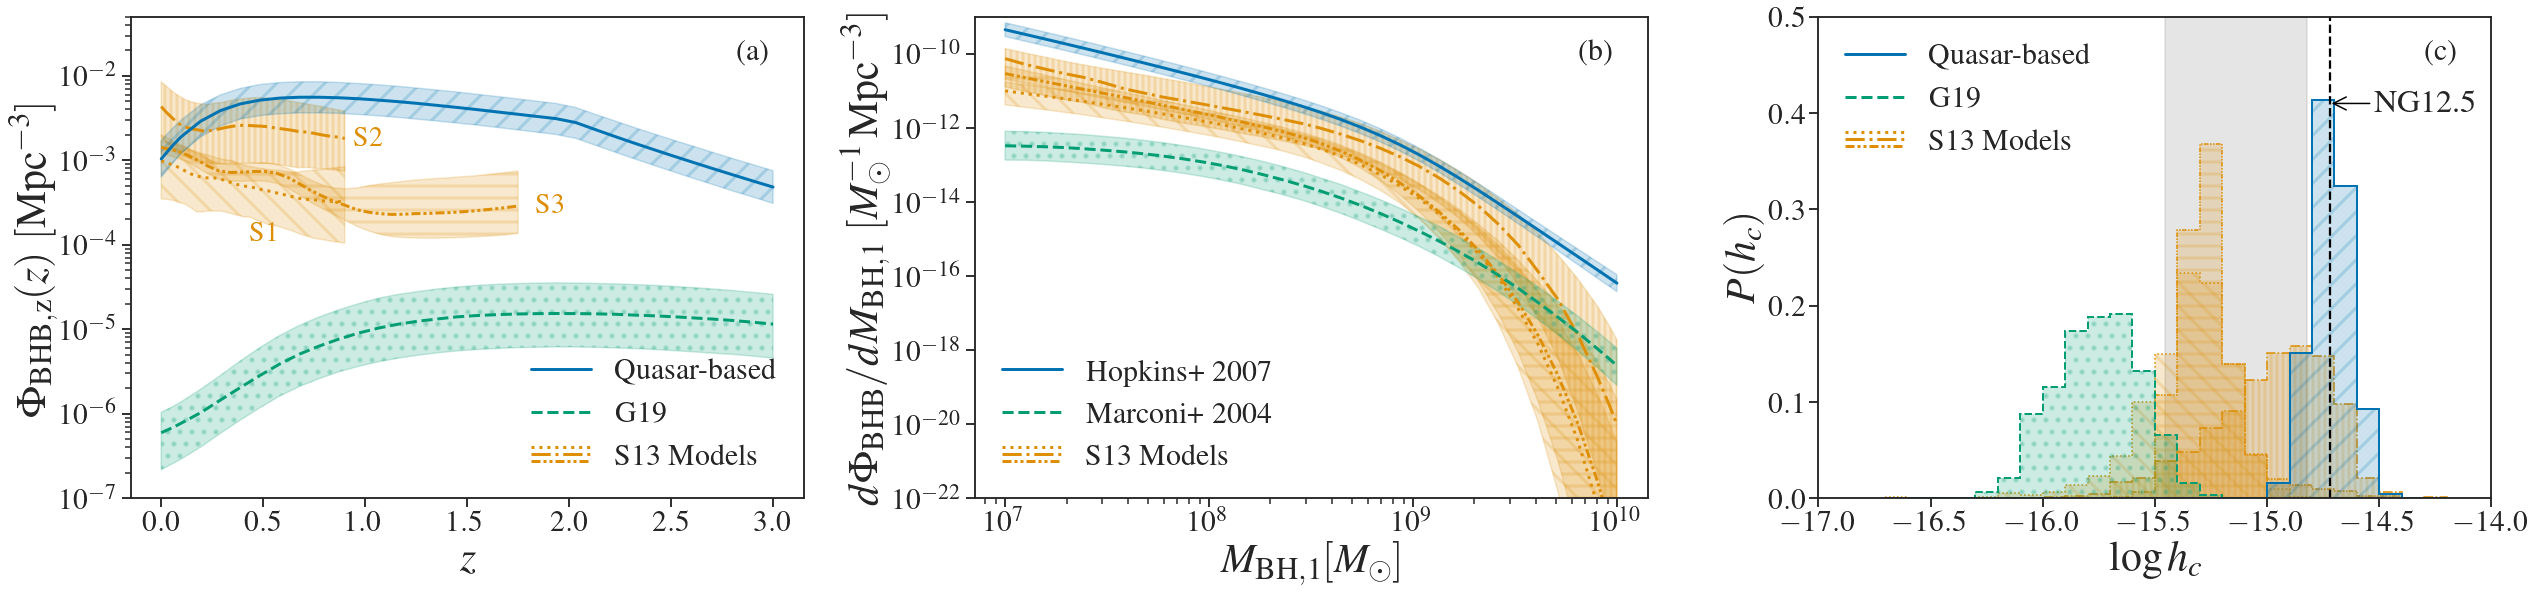

In [185]:
log_nz_i_l_kw_fid_min = np.floor(np.min(np.log10([np.min(differential_number_density_q[1]), np.min(S1_number_density_q[1]),
                                                  np.min(S2_number_density_q[1]), np.min(S3_number_density_q[1])])))
log_nz_i_l_kw_fid_max = np.ceil(np.max(np.log10([np.max(differential_number_density_q[1]), np.max(S1_number_density_q[1]),
                                                 np.max(S2_number_density_q[1]), np.max(S3_number_density_q[1])])))


log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                            S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                           S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(hc_q[1, -1, -1, -1])
log_hc_min = np.log10(hc_q[0, -1, -1, -1])
log_hc_max = np.log10(hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(1, 3, figsize=(36, 9))

label_fsize = 42
legend_fsize = 30
text_fs = 28

ax[0].tick_params()
ax[1].tick_params()

ax[0].fill_between(z_range_borch, S1_number_density_q[0], S1_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='\\')
s1, = ax[0].plot(z_range_borch, S1_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=':')
ax[0].text(z_range_borch[int(n_mesh / 2) - 1], .9 * S1_number_density_q[0, int(n_mesh / 2) - 1], 'S1', color=cs[1],
           verticalalignment='top', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range_drory, S2_number_density_q[0], S2_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='||')
s2, = ax[0].plot(z_range_drory, S2_number_density_q[1], color=cs[1],
                linewidth=3, linestyle='-.')
ax[0].text(1.05 * z_range_drory[n_mesh - 1], S2_number_density_q[1, n_mesh - 1], 'S2', color=cs[1],
           verticalalignment='center', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range_ilbert, S3_number_density_q[0], S3_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='-')
s3, = ax[0].plot(z_range_ilbert, S3_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[0].text(1.05 * z_range_ilbert[n_mesh - 1], S3_number_density_q[1, n_mesh - 1], 'S3', color=cs[1],
           verticalalignment='center', horizontalalignment='left', fontsize=text_fs)

ax[0].fill_between(z_range, G19_number_density_q[0], G19_number_density_q[2], color=cs[2], alpha=.2, hatch='.')
m2, = ax[0].plot(z_range, G19_number_density_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[0].fill_between(z_range, differential_number_density_q[0], differential_number_density_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[0].plot(z_range, differential_number_density_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\Phi_{\rm{BHB}, z}(z)\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0].set_xlabel(r'$z$', fontsize=label_fsize)
# ax[0].set_ylim((10 ** (log_nz_i_l_kw_fid_min - 1), 10 ** (log_nz_i_l_kw_fid_max + 1)))
ax[0].set_ylim(top=5e-2, bottom=1e-7)

ax[0].legend([m1, m2, (s1, s2, s3)], ['Quasar-based', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower right', frameon=False, fontsize=legend_fsize)

ax[0].text(.95, .95, '(a)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[0].transAxes)

ax[1].fill_between(10 ** log_m_bh_range, S1_total_bhmf_q[0], S1_total_bhmf_q[2], color=cs[1], alpha=.2, hatch='\\')
s1, = ax[1].plot(10 ** log_m_bh_range, S1_total_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=':')
ax[1].fill_between(10 ** log_m_bh_range, S2_total_bhmf_q[0], S2_total_bhmf_q[2], color=cs[1], alpha=.2, hatch='||')
s2, = ax[1].plot(10 ** log_m_bh_range, S2_total_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle='-.')
ax[1].fill_between(10 ** log_m_bh_range, S3_total_bhmf_q[0], S3_total_bhmf_q[2], color=cs[1], alpha=.2, hatch='-')
s3, = ax[1].plot(10 ** log_m_bh_range, S3_total_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))

ax[1].fill_between(10 ** log_m_bh_range, G19_total_bhmf_q[0][log_m_chirp_range != log_m_chirp_norm_min],
                   G19_total_bhmf_q[2][log_m_chirp_range != log_m_chirp_norm_min], color=cs[2], alpha=.2, hatch='.')
m2, = ax[1].plot(10 ** log_m_bh_range, G19_total_bhmf_q[1][log_m_chirp_range != log_m_chirp_norm_min], color=cs[2], linewidth=3, linestyle='--')

ax[1].fill_between(10 ** log_m_bh_range, total_bhmf_q[0], total_bhmf_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[1].plot(10 ** log_m_bh_range, total_bhmf_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}, 1}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1].set_xlabel(r'$M_{\rm{BH}, 1} [M_{\odot}]$', fontsize=label_fsize)
ax[1].set_ylim(bottom=1e-22, top=1e-9)
ax[1].legend([m1, m2, (s1, s2, s3)], ['Hopkins+ 2007', 'Marconi+ 2004', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower left', frameon=False, fontsize=legend_fsize)
ax[1].text(.95, .95, '(b)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[1].transAxes)

ax[2].axvspan(log_sesana_min, log_sesana_max, color='k', alpha=.1)
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='\\')
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='||')
ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='-')
ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(G19_hc[-1, -1, :]), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_hc[-1, -1, :]), len(G19_hc[-1, -1, :])), linewidth=2, fill=True, alpha=.2, hatch='.')
ax[2].hist(np.log10(G19_hc[-1, -1, :]), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_hc[-1, -1, :]), len(G19_hc[-1, -1, :])), linewidth=2)

ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'Quasar-based', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'Quasar-based', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2)

ax[2].axvline(np.log10(1.9e-15), color='k', linestyle='--')
ax[2].annotate(r'NG12.5',
               xy=(np.log10(1.9e-15), .41), xytext=(np.log10(1.9e-15) + 0.2, .41), xycoords='data', textcoords='data',
               arrowprops=dict(arrowstyle="->", linestyle='-', color='k',
                              relpos=(0,.5)), ha='left', va='center')
ax[2].set_xlabel(r'$\log h_{c}$', fontsize=label_fsize)
ax[2].set_ylabel(r'$P(h_{c})$', fontsize=label_fsize)
ax[2].set_xlim(left=-17, right=-14)
ax[2].set_ylim(top=.5)
ax[2].legend([m1, m2, (s1, s2, s3)], ['Quasar-based', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)
ax[2].text(.95, .95, '(c)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[2].transAxes)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.pdf')
plt.savefig('../reports/figures/model_comparison.png')
plt.show()

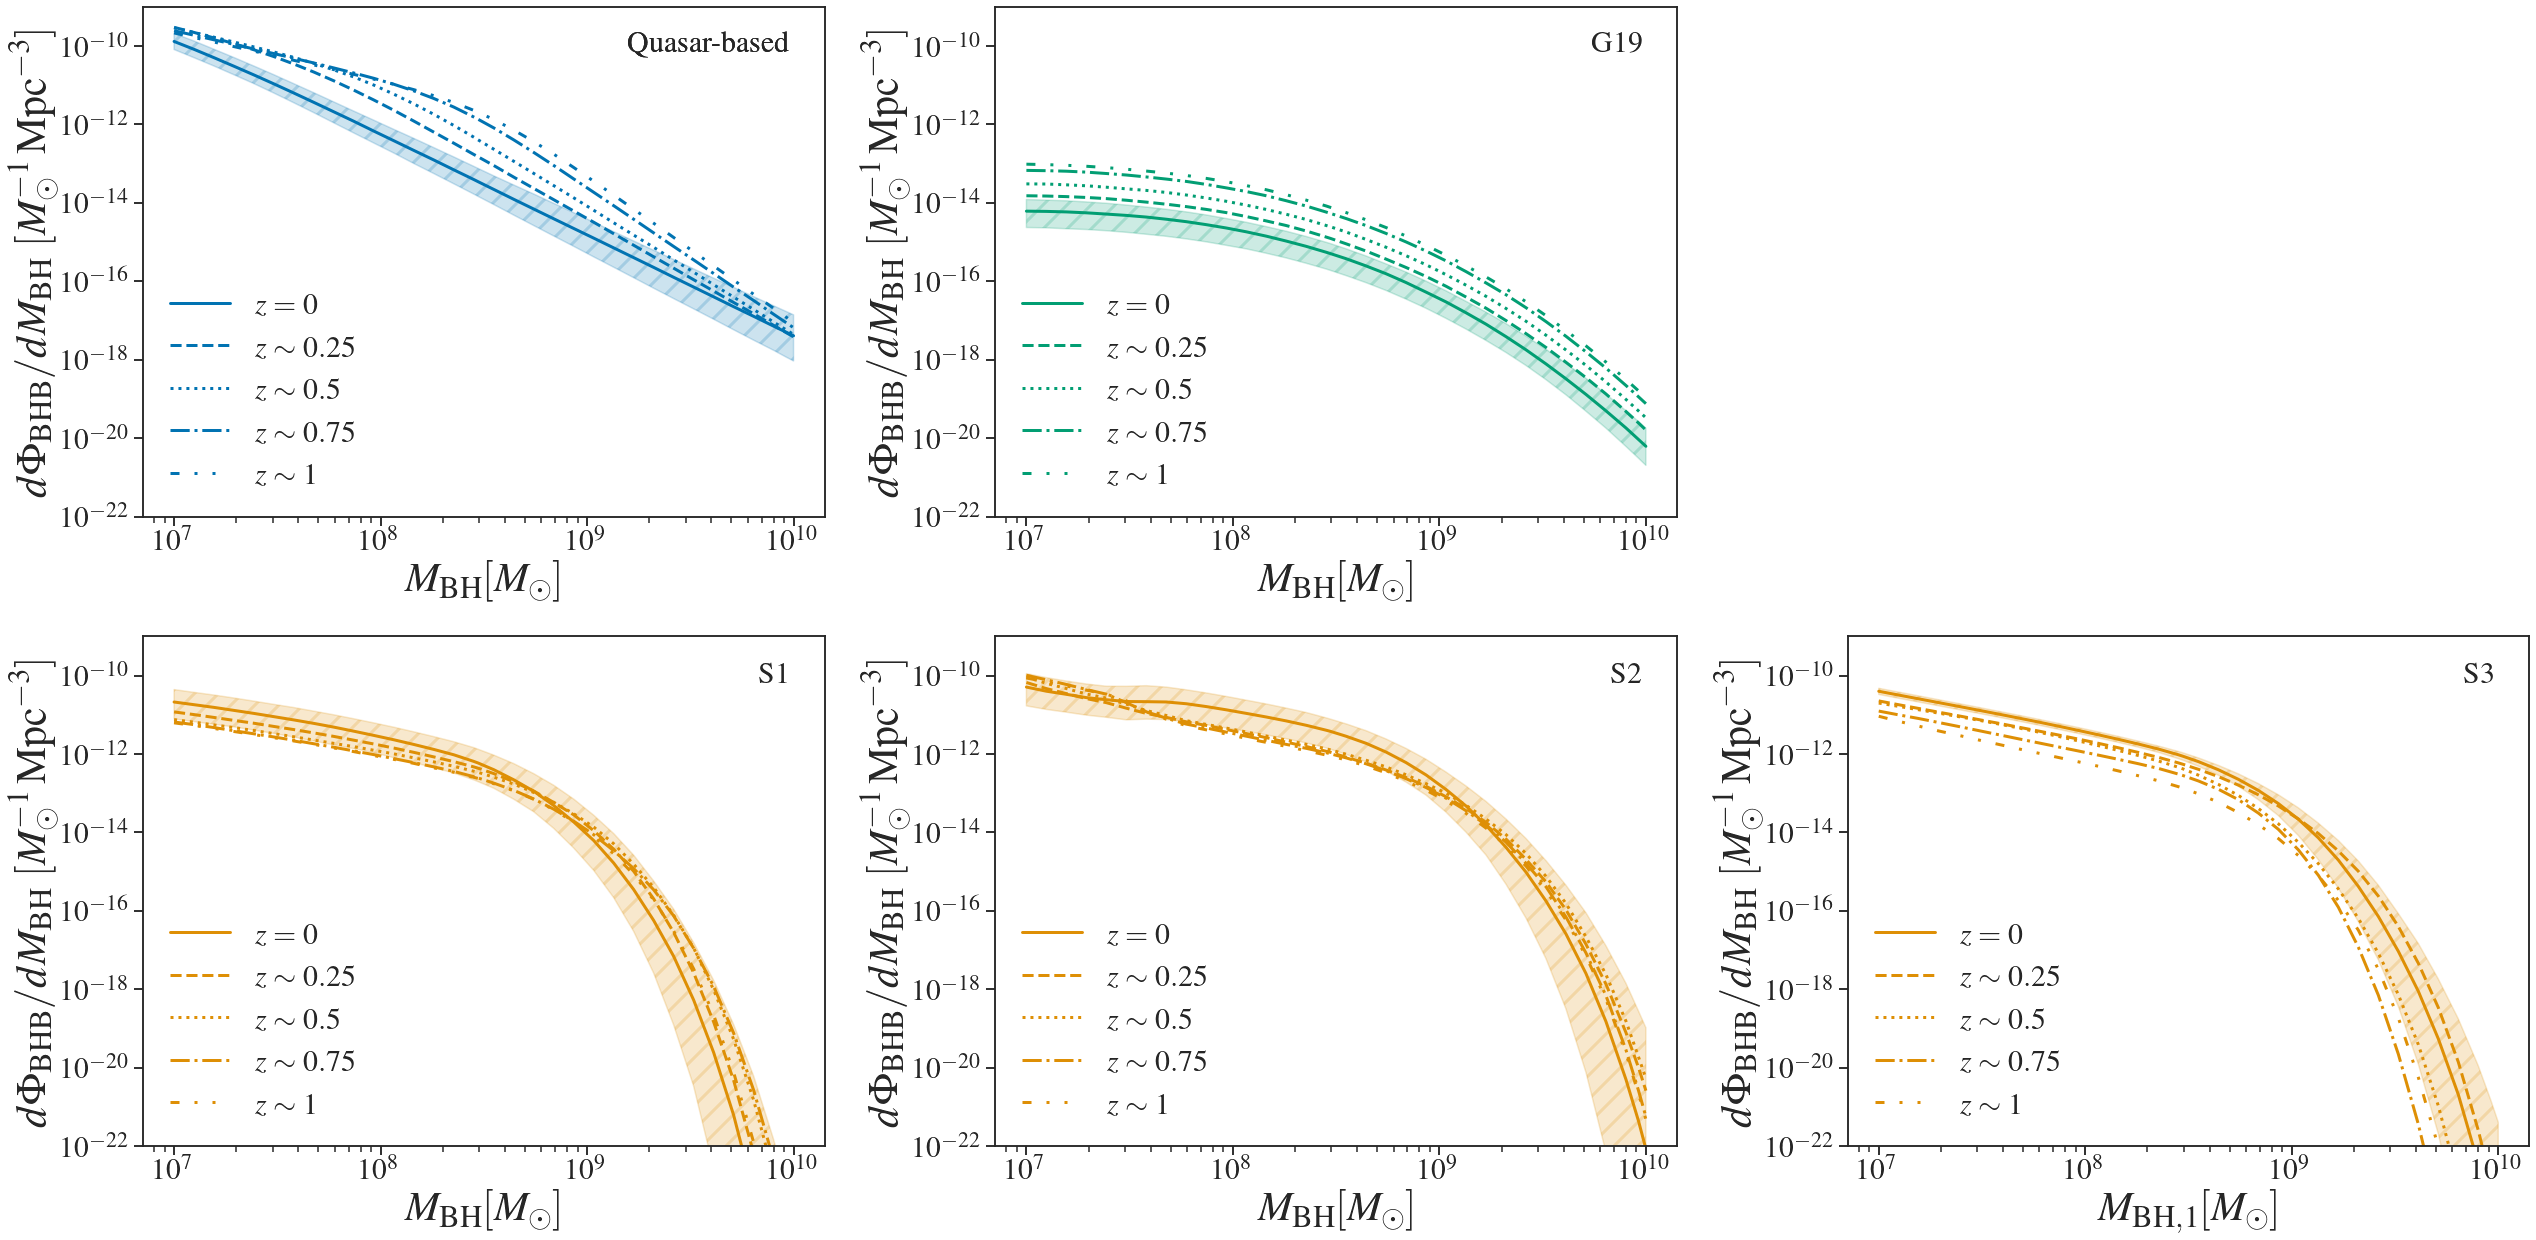

In [186]:
sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(2, 3, figsize=(36, 18))

label_fsize = 42
legend_fsize = 30
text_fs = 28

ax[0, 0].tick_params()
ax[0, 1].tick_params()


ax[0, 0].fill_between(10 ** log_m_bh_range, bhmf_q[0, :, 0], bhmf_q[2, :, 0], color=cs[0], alpha=.2, hatch='/')
ax[0, 0].plot(10 ** log_m_bh_range, bhmf_q[1, :, 0], color=cs[0], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[0, 0].plot(10 ** log_m_bh_range, np.squeeze(bhmf_q[1, :, np.abs(.25 - z_range) == np.min(np.abs(.25 - z_range))]),
           color=cs[0], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[0, 0].plot(10 ** log_m_bh_range, np.squeeze(bhmf_q[1, :, np.abs(.5 - z_range) == np.min(np.abs(.5 - z_range))]),
           color=cs[0], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[0, 0].plot(10 ** log_m_bh_range, np.squeeze(bhmf_q[1, :, np.abs(.75 - z_range) == np.min(np.abs(.75 - z_range))]),
           color=cs[0], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[0, 0].plot(10 ** log_m_bh_range, np.squeeze(bhmf_q[1, :, np.abs(1 - z_range) == np.min(np.abs(1 - z_range))]),
           color=cs[0], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')
ax[0, 0].text(.95, .95, 'Quasar-based', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[0, 0].transAxes)

ax[0, 0].text(.95, .95, 'Quasar-based', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[0, 0].transAxes)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0, 0].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[0, 0].set_ylim(bottom=1e-22, top=1e-9)
ax[0, 0].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

ax[0, 1].fill_between(10 ** log_m_bh_range, G19_bhmf_q[0, log_m_chirp_range != log_m_chirp_norm_min, 0],
                      G19_bhmf_q[2, log_m_chirp_range != log_m_chirp_norm_min, 0], color=cs[2], alpha=.2, hatch='/')
ax[0, 1].plot(10 ** log_m_bh_range, G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, 0], color=cs[2], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[0, 1].plot(10 ** log_m_bh_range, np.squeeze(G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, np.abs(.25 - z_range) == np.min(np.abs(.25 - z_range))]),
           color=cs[2], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[0, 1].plot(10 ** log_m_bh_range, np.squeeze(G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, np.abs(.5 - z_range) == np.min(np.abs(.5 - z_range))]),
           color=cs[2], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[0, 1].plot(10 ** log_m_bh_range, np.squeeze(G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, np.abs(.75 - z_range) == np.min(np.abs(.75 - z_range))]),
           color=cs[2], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[0, 1].plot(10 ** log_m_bh_range, np.squeeze(G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, np.abs(1 - z_range) == np.min(np.abs(1 - z_range))]),
           color=cs[2], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')

ax[0, 1].text(.95, .95, 'G19', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[0, 1].transAxes)
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0, 1].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[0, 1].set_ylim(bottom=1e-22, top=1e-9)
ax[0, 1].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

ax[0, 2].set_axis_off()

ax[1, 0].fill_between(10 ** log_m_bh_range, S1_bhmf_q[0, :, 0], S1_bhmf_q[2, :, 0], color=cs[1], alpha=.2, hatch='/')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, 0], color=cs[1], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, np.abs(.25 - z_range_borch) == np.min(np.abs(.25 - z_range_borch))][0],
           color=cs[1], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, np.abs(.5 - z_range_borch) == np.min(np.abs(.5 - z_range_borch))][0],
           color=cs[1], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, np.abs(.75 - z_range_borch) == np.min(np.abs(.75 - z_range_borch))][0],
           color=cs[1], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, np.abs(1 - z_range_borch) == np.min(np.abs(1 - z_range_borch))][0],
           color=cs[1], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')
ax[1, 0].text(.95, .95, 'S1', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[1, 0].transAxes)

ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1, 0].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[1, 0].set_ylim(bottom=1e-22, top=1e-9)
ax[1, 0].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

ax[1, 1].fill_between(10 ** log_m_bh_range, S2_bhmf_q[0, :, 0], S2_bhmf_q[2, :, 0], color=cs[1], alpha=.2, hatch='/')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, 0], color=cs[1], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, np.abs(.25 - z_range_drory) == np.min(np.abs(.25 - z_range_drory))][0],
           color=cs[1], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, np.abs(.5 - z_range_drory) == np.min(np.abs(.5 - z_range_drory))][0],
           color=cs[1], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, np.abs(.75 - z_range_drory) == np.min(np.abs(.75 - z_range_drory))][0],
           color=cs[1], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, np.abs(1 - z_range_drory) == np.min(np.abs(1 - z_range_drory))][0],
           color=cs[1], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')
ax[1, 1].text(.95, .95, 'S2', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[1, 1].transAxes)

ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1, 1].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[1, 1].set_ylim(bottom=1e-22, top=1e-9)
ax[1, 1].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

ax[1, 2].fill_between(10 ** log_m_bh_range, S3_bhmf_q[0, :, 0], S3_bhmf_q[2, :, 0], color=cs[1], alpha=.2, hatch='/')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, 0], color=cs[1], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, np.abs(.25 - z_range_ilbert) == np.min(np.abs(.25 - z_range_ilbert))][0],
               color=cs[1], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, np.abs(.5 - z_range_ilbert) == np.min(np.abs(.5 - z_range_ilbert))][0],
               color=cs[1], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, np.abs(.75 - z_range_ilbert) == np.min(np.abs(.75 - z_range_ilbert))][0],
               color=cs[1], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, np.abs(1 - z_range_ilbert) == np.min(np.abs(1 - z_range_ilbert))][0],
             color=cs[1], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')
ax[1, 2].text(.95, .95, 'S3', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[1, 2].transAxes)

ax[1, 2].set_xscale('log')
ax[1, 2].set_yscale('log')
ax[1, 2].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1, 2].set_xlabel(r'$M_{\rm{BH}, 1} [M_{\odot}]$', fontsize=label_fsize)
ax[1, 2].set_ylim(bottom=1e-22, top=1e-9)
ax[1, 2].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

plt.tight_layout()
plt.savefig('../reports/figures/bhmf.pdf')
plt.savefig('../reports/figures/bhmf.png')
plt.show()

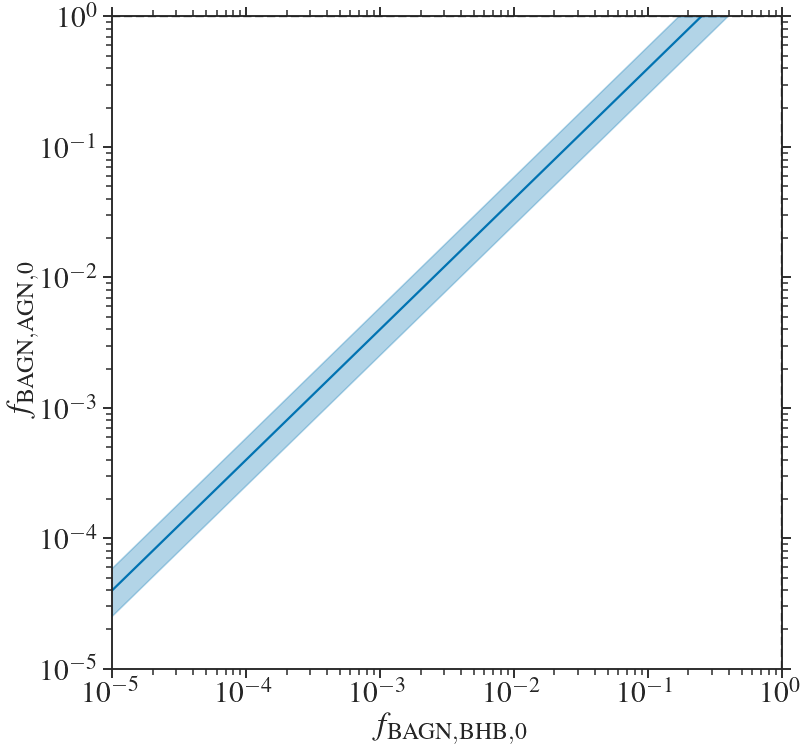

In [187]:
plt.figure(figsize=(12, 12))
# plt.plot(f_bagn_bhb_space, f_bagn_agn_q[1], color=cs[0])
# plt.fill_between(f_bagn_bhb_space, f_bagn_agn_q[0], f_bagn_agn_q[2], color=cs[0], alpha=.3)

f_bagn_bhb_q = np.quantile(f_bagn_bhb, q=[.16, .5, .84], axis=-1)

plt.plot(f_bagn_bhb_q[1], f_bagn_agn_space, color=cs[0])
plt.fill_betweenx(f_bagn_agn_space, f_bagn_bhb_q[0], f_bagn_bhb_q[2], color=cs[0], alpha=.3)
# plt.scatter(np.repeat(f_bagn_bhb_space[:, np.newaxis], n_samples, axis=1), f_bagn_agn)
# plt.scatter(f_bagn_bhb, np.repeat(f_bagn_agn_space[:, np.newaxis], n_samples, axis=1))
plt.axhline(1, color='k', linestyle='--')
plt.axvline(1, color='k', linestyle='--')

plt.xscale('log')
plt.xlim(right=1, left=1e-5)
plt.xlabel(r'$f_{\rm{BAGN, BHB}, 0}$')

plt.yscale('log')
plt.ylim(top=1, bottom=1e-5)
plt.ylabel(r'$f_{\rm{BAGN, AGN}, 0}$')

plt.tick_params(which='both', top=True, right=True)

plt.savefig('../reports/figures/frac_ratio.pdf')
plt.savefig('../reports/figures/frac_ratio.png')
plt.show()